# <span style="color: royalblue;">Week 4: NLP Disaster Tweets Kaggle Mini-Project</span>

<span style="font-size: 18px; font-weight: bold; color: royalblue;">Natural Language Processing with Disaster Tweets:</span>

For the week 4 assignment, I will predict which Tweets (or posts) are discussing real disasters and which are not (a classification problem). In the example for this Kaggle competition it showed a Tweet (or post), "On the plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE". It mentions that for a human, this is easy to know the poster was talking about the sunset and was using "ABLAZE" metaphorically, but is less clear to a machine.

Natural language processing (NLP) is a subfield of AI focused techniques for understanding human language. Words in a Tweet can indicate whether the content relates to a disaster. Classification can be done in many different ways: a simple model that assumes a linear relationship between the words and classification, or a more advanced model capable of uncovering complex, non-linear relationships.

The Kaggle competition also noted that the F1 score is what they will use for rankings. I will keep this in mind for this project and make sure to show it along with the accuracy that is typically used with measuring neural network performance.

To classify each post as disaster (or not), there will be two main parts: Tokenizing the text and using those tokens in a deep learning model. Tokenizing will turn the text from the post into numbers that the deep-learning model can work with.

This week, we were introduced to recurrent neural networks (RNNs) and two specific implementations: long short-term memory (LSTM) and gated recurrent units (GRU). I will first try a basic vanilla RNN and then try updated architectures (LSTM and GRU).

The results will be submitted to the Kaggle competition to see how well the model generalizes to unseen data.

<span style="font-size: 15px; font-weight: bold;">Dataset:</span>

Howard, A., devrishi, Culliton, P., & Guo, Y. (2019). Natural Language Processing with Disaster Tweets. Kaggle. Retrieved March 14, 2025, from https://kaggle.com/competitions/nlp-getting-started

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Setup:</span>

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import os
import random
import re
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
import matplotlib.pyplot as plt
import contractions
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Bidirectional, GRU, LSTM, Dense, Dropout
from tensorflow.keras.metrics import AUC
from keras.optimizers import Adam
from keras.initializers import Orthogonal
from keras import regularizers
from abc import ABC, abstractmethod

%matplotlib inline

In [2]:
SEED_VALUE = 100
DISPLAY_FONT_SIZE = 14
TITLE_FONT_SIZE = 14

# Set the seed
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Remove restriction on column display widths:
pd.set_option('display.max.colwidth', None)

# Customizing dataframe table display with larger font.
display(HTML(f"<style>table.dataframe th, table.dataframe td {{font-size: {DISPLAY_FONT_SIZE}px;}}</style>"))

# Custom function for key, value pair display
def custom_display(title, value=None):
    """
    Prints output with larger font and bold title.
    """
    display(HTML(f'<span style="font-size:{DISPLAY_FONT_SIZE}px;"><b>{title}</b>{f": {value}" if value is not None else ""}</span>'))

# Custom display of a data frame table and title.
class DataFrameDisplayManager:
    """
    Used to display a single dataframe with a title.
    """
    def __init__(self):
        pass
    def display(self, df, title, color):
        display(HTML(f"""
            <div style="display: grid; grid-template-columns: repeat(1, 1fr); grid-template-rows: repeat(2, 0.1fr); gap: 10px;">
                <div style="text-align: center; font-size: {TITLE_FONT_SIZE*1.2}px; font-weight: bold;">{title}</div>
                <div style="display: flex; justify-content: center; background-color: {color};">{df.round(2).to_html(index=False)}</div>
            </div>
        """))
        
df_manager = DataFrameDisplayManager()

In [3]:
# Configure GPU
mixed_precision.set_global_policy('mixed_float16')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070 SUPER, compute capability 8.9


## <span style="color: royalblue;">A Closer Look at the Data</span>

In [4]:
# data directory must be at the same level as this Jupyter Notebook file
train_df = pd.read_csv(os.path.join('data', 'nlp-getting-started', 'train.csv'))
test_df = pd.read_csv(os.path.join('data', 'nlp-getting-started', 'test.csv'))

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Train Data:</span>

In [5]:
# Training
df_manager.display(train_df.head(5), "Train Data Head:", "lightblue")
custom_display("Train Data Info:")
print(train_df.info())
custom_display("Train Data Shape:", train_df.shape)

id,keyword,location,text,target
1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Test Data:</span>

In [6]:
#Test
df_manager.display(test_df.head(5), "Test Data Head:", "lightblue")
custom_display("Test Data Info:")
print(test_df.info())
custom_display("Test Data Shape:", test_df.shape)

id,keyword,location,text
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, stay safe everyone."
3,NaN,NaN,"there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all"
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Observations:</span>
* We can see there a number of **NaN** values in the **keyword** and **location** columns. I will address this in the **data cleaning** section later.
* The training dataset is relatively small with **7613 rows**.
* The **target** column is an **int64** datatype. This will work fine with classification.
* The **text** column is type **object**. This is likely fine, but I will look at it more in the **EDA** section.
* From the 5 rows shown we can already see there will be some special characters to deal with (e.g. #).
* The memory usage for both the test and train are low.

I will now examine the data more closely in the following **EDA** and **Data Cleaning** section.

## <span style="color: royalblue;">Exploratory Data Analysis (EDA) and Data Cleaning</span>
Above we took a quick look at the data to see what we are dealing with. We learned the data set is not very big. There are 7613 rows of training data. This will have to be split into a test and validation set for proper training with a neural network. I will be conscious of the small amount of data available so that the model adequately generalize on unseen data.

There are several **NaN** values in the **keyword** and **location** columns. Often if this is the case we would have to either remove those rows or substitute values into those fields (such as an average value), but in this project, those values won't be used. I could just leave those columns in since they will be ignored, but to keep the data clean, I will remove them.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Removing unused columns from the data frames:</span>

In [7]:
train_df.drop(columns=['keyword', 'location'], inplace=True)
test_df.drop(columns=['keyword', 'location'], inplace=True)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Verifying the columns are gone:</span>

In [8]:
 custom_display("train_df columns: ", train_df.columns.tolist())
 custom_display("test_df columns: ", test_df.columns.tolist())

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Checking for missing values in training_df:</span>

In [9]:
print(train_df.isnull().sum())

id        0
text      0
target    0
dtype: int64


After removing the unused columns "keyword" and "location" there are no missing values.

Also, we saw that the **text** column was of type **object**. This should be fine, but Pandas recommends **StringDtype** for text data so I will convert the text column to type 'StringDtype'. 

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Converting 'text' column to type StringDtype:</span>

In [10]:
train_df['text'] = train_df['text'].astype(pd.StringDtype())
test_df['text'] = test_df['text'].astype(pd.StringDtype())

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Verifying 'text' is now StringDtype:</span>

In [11]:
custom_display("train_df:")
display(train_df.dtypes.to_frame(name="Data type"))
print("")
custom_display("test_df:")
display(test_df.dtypes.to_frame(name="Data type"))

,Data type
id,int64
text,string[python]
target,int64


,Data type
id,int64
text,string[python]


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Duplicate Check</span>

I will see if there are any duplicate entries in the training data.

In [12]:
duplicate_count = train_df.duplicated(subset=['text'], keep='first').sum()
custom_display("Duplicate tweets (posts) in train_df: ", duplicate_count)

There are 110 duplicate posts in the training data. Duplicate rows are unnecessary and could cause problems:
* Overfitting
* Inflating the training accuracy value
* Bias
* Computational time

I will remove this duplicates:

<span style="font-size: 15px; font-weight: bold;">Removing duplicates:</span>

In [13]:
train_df = train_df.drop_duplicates(subset=['text'], keep='first')

Verifying the duplicates are now gone:

In [14]:
duplicate_count = train_df.duplicated(subset=['text'], keep='first').sum()
custom_display("Duplicate tweets (posts) in train_df after removal: ", duplicate_count)

Let's get a shape of the data after duplicate removals:

In [15]:
custom_display("Train Data Shape (after duplicate removal):", train_df.shape)

This shows that the duplicate rows have been removed.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Word-Frequency Histograms</span>

Using a word-frequency histogram we can see what the most prominent words in the dataset. This will allow us to remove words that might hinder the training and inference generalization process.

The TokenizerManager class will support the management of tokens for the data.

In [16]:
class TokenizerManager:
    """
    Manages the creation of tokens from the text data.
    """
    def __init__(self, num_words, data_frame, remove_contractions=False):
        self.num_words = num_words
        self.field = 'text'

        # Fix contractions
        if remove_contractions:
            data_frame[self.field] = data_frame[self.field].apply(lambda text: contractions.fix(text))

        self.data_frame = data_frame

        self.tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
        self.tokenizer.fit_on_texts(data_frame[self.field])
        
    def get_sequences(self, target=[0,1]):
        """
        Convert texts to sequences
        """
        return self.tokenizer.texts_to_sequences(self.data_frame.loc[self.data_frame['target'].isin(target), self.field])

In [17]:
class WordFrequencyHistogramManager:
    """
    Manages the display of the word histrograms
    """
    def __init__(self, tokenizer_manager):
        self.tokenizer_manager = tokenizer_manager

    def __get_words_and_counts(self, num_words, target=[0,1]):
        sequences = self.tokenizer_manager.get_sequences(target)
        word_counts = Counter([word for seq in sequences for word in seq])
        
        return zip(*word_counts.most_common(num_words))
        
    def display_all_categories(self, num_words, title):
        """
        This includes both non-disaster and disaster classified words.
        """
        words, counts = self.__get_words_and_counts(num_words)
        word_labels = [self.tokenizer_manager.tokenizer.index_word[word] for word in words]
        
        plt.figure(figsize=(13, 7))
        plt.bar(word_labels, counts, color="blueviolet", edgecolor="black")
        plt.xlabel("Words")
        plt.ylabel("Frequency")
        plt.title(title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        plt.xticks(rotation=70)
        plt.show()

    def display_by_categories(self, num_words, title):
        """
        Creates side-by-side plots of non-disaster and disaster word frequency histograms
        """
        words, negative_counts = self.__get_words_and_counts(num_words, [0])
        negative_word_labels = [self.tokenizer_manager.tokenizer.index_word[word] for word in words]

        words, positive_counts = self.__get_words_and_counts(num_words, [1])
        positive_word_labels = [self.tokenizer_manager.tokenizer.index_word[word] for word in words]

        def add_plot(ax, title, word_labels, word_counts, color):
            """
            Convenience method to add the graphical components
            """
            ax.bar(word_labels, word_counts, color=color, edgecolor="black")
            ax.set_xlabel("Words")
            ax.set_ylabel("Frequency")
            ax.set_title(title)
            ax.set_xticks(range(len(word_labels)))
            ax.set_xticklabels(word_labels, rotation=70)

        figure = plt.figure(figsize=(13, 7))
        figure.suptitle(title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0, 1])

        # Side-by-side plots
        ax0 = figure.add_subplot(gs[0])
        ax1 = figure.add_subplot(gs[2])

        add_plot(ax0, "Non-Disaster", negative_word_labels, negative_counts, "gold")
        add_plot(ax1, "Disaster", positive_word_labels, positive_counts, "royalblue")

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Plot Histograms</span>

I'll keep a rather large number of words in the vocabulary to be tokenized.

In [18]:
tokenizer_manager = TokenizerManager(22300, train_df, True)
word_frequency_histogram_manager = WordFrequencyHistogramManager(tokenizer_manager)

First I will display the top 40 words for both the non-disaster and disaster Tweets/Posts.

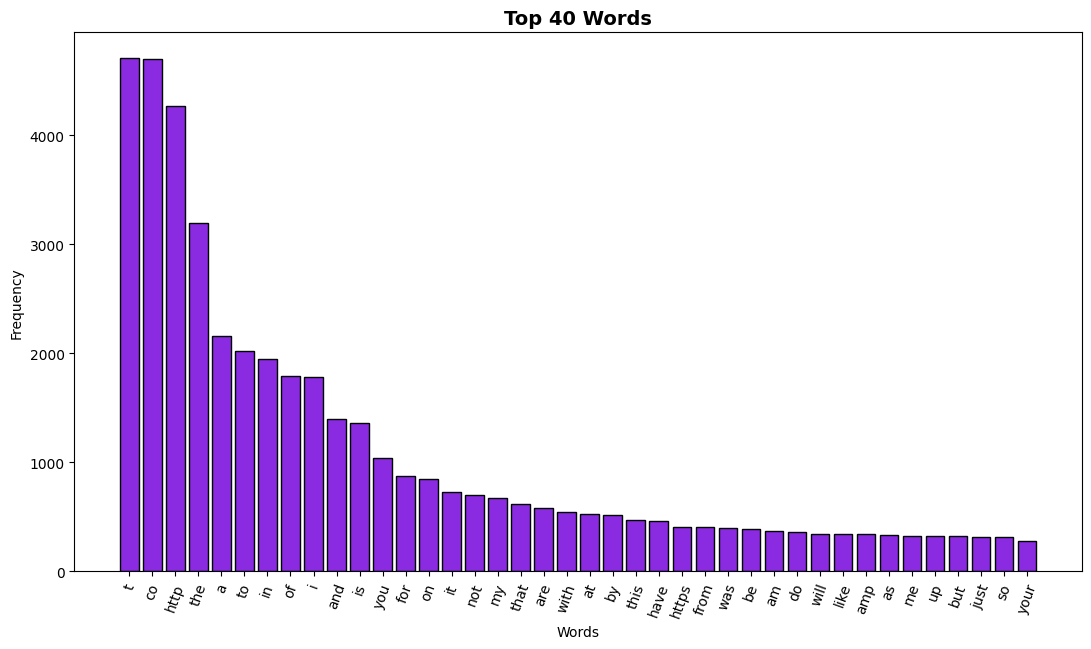

In [19]:
word_frequency_histogram_manager.display_all_categories(40, "Top 40 Words")

At the top of the list for most prominent words we can see some odd ones: 't', and 'co'. What are those? And do we need them? I will list some of them out:

In [20]:
display(train_df[train_df['text'].str.contains(r'\bt\b', case=False, na=False)])

,id,text,target
31,48,@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C,1
32,49,We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw,0
33,50,#AFRICANBAZE: Breaking news:Nigeria flag set ablaze in Aba. http://t.co/2nndBGwyEi,1
35,53,On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE http://t.co/qqsmshaJ3N,0
37,55,INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA,1
...,...,...,...
7603,10862,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1
7604,10863,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1
7606,10866,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1
7608,10869,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1


It occurs in A LOT of the text. Looks like just a bunch shorthand URLs to Twitter (now X). I don't think those will hold much value in this classification problem, so I will remove any URL-related string.

Next I will show the top 25 words separately for the non-disaster and disaster Tweets/Posts.

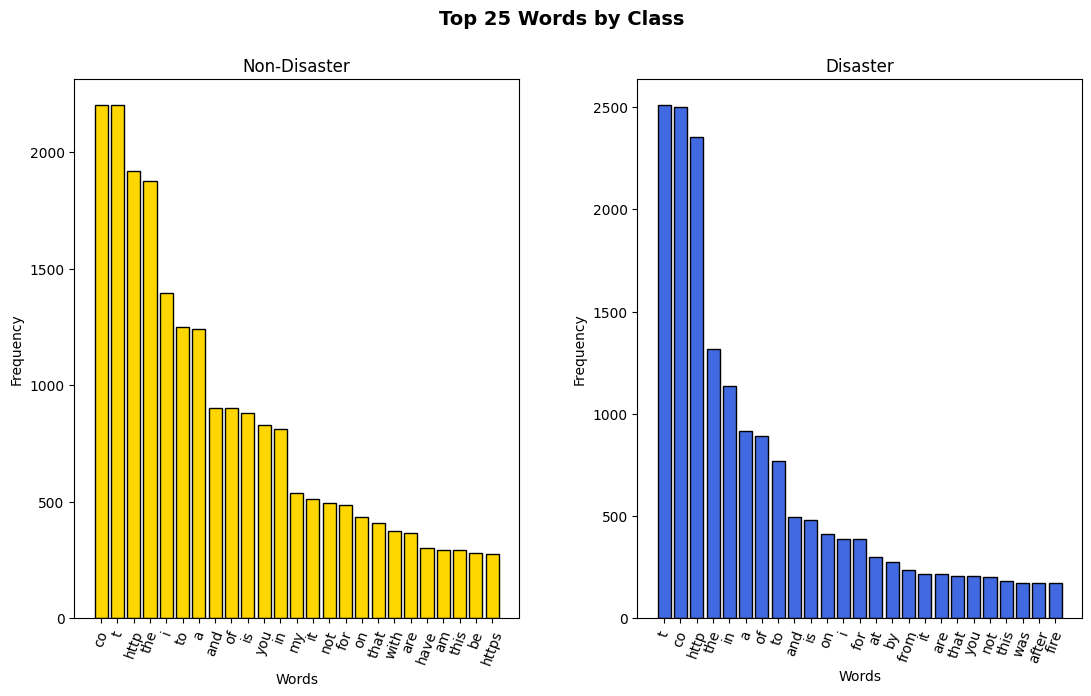

In [21]:
word_frequency_histogram_manager.display_by_categories(25, "Top 25 Words by Class")

Looking at the two plots there are several words that are in common that could make the classification task more difficult for the model. I won't remove them all, but just a few of the top ones that look like they don't hold much value in a classification task. It is important to note that an RNN won't have as much difficulty as a simpler model, but I want to try for a decently high score so perhaps removing unnecessary words will help.

In [22]:
words_to_remove = ['the', 'in', 'to', 'a', 'and', 'of']
patterns_to_remove = [r'http\S+']

I think that's a fair start. I can revisit this later if needed. I will go ahead and remove these words (and http pattern). It is important to note, any words removed in the training data should also be removed from the test data to keep things consistent.

I don't want to remove too many words however as with a RNN, seemingly unimportant words might carry context that makes the predictions more accurate. For example, 'not' combined with 'a disaster' has a very important meaning.

Class to manage the removal:

In [23]:
class WordRemovalManager:
    def __init__(self, train_df):
        self.data_df = train_df

    def remove_patterns(self, pattern_list):
        combined_patterns ='|'.join(pattern_list)
        self.data_df['text'] = self.data_df['text'].apply(lambda x: re.sub(combined_patterns, '', x, flags=re.IGNORECASE).strip())

    def remove_words(self, word_list):
        self.data_df['text'] = self.data_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in words_to_remove]))

Removing the URL pattern and words:

In [24]:
train_word_removal_manager = WordRemovalManager(train_df)
test_word_removal_manager = WordRemovalManager(test_df)

# Removing the URL pattern first
train_word_removal_manager.remove_patterns(patterns_to_remove)
test_word_removal_manager.remove_patterns(patterns_to_remove)

# Removing the list of words
train_word_removal_manager.remove_words(words_to_remove)
test_word_removal_manager.remove_words(words_to_remove)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Word Cloud</span>

Another visual way to see the dominant words, is to use a word cloud. This will verify that the words (and pattern text) was removed.

Class to manage the displaying of the word clouds:

In [25]:
class WordCloudManager:
    """
    Manages the displaying of the word clouds
    """
    width = 800
    height = 400
    
    def __init__(self, train_df):
        self.train_local_df = train_df.copy()

    def display_word_cloud(self):
        word_cloud = self.__filter_by_target(WordCloudManager.width, WordCloudManager.height)

        _, ax = plt.subplots(figsize=(13, 7))
        ax.imshow(word_cloud, interpolation='bilinear')
        ax.axis('off')

        # Center the image
        ax.set_xlim(-0.03 * WordCloudManager.width, WordCloudManager.width)
        
        plt.title('Word Cloud (All)', fontsize=TITLE_FONT_SIZE, fontweight='bold')
        plt.show()

    def __filter_by_target(self, width, height, target=[0, 1]):
        filtered_series = self.train_local_df.loc[self.train_local_df['target'].isin(target)]['text']
        return WordCloud(width=width, height=height, background_color='white', random_state=SEED_VALUE).generate(" ".join(filtered_series))
        
    def display_word_cloud_by_classes(self):
        def add_word_cloud(current_ax, word_cloud, title):
            current_ax.imshow(word_cloud, interpolation='bilinear')
            current_ax.axis('off')
            current_ax.set_title(title, fontsize=TITLE_FONT_SIZE, fontweight='bold', loc='center')

        negative_word_cloud = self.__filter_by_target(WordCloudManager.width, WordCloudManager.height, [0])
        positive_word_cloud = self.__filter_by_target(WordCloudManager.width, WordCloudManager.height, [1])

        figure, ax = plt.subplots(figsize=(13, 4))
        figure.suptitle("Word Cloud", fontsize=TITLE_FONT_SIZE, fontweight='bold')
        ax.axis('off')
        
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

        add_word_cloud(figure.add_subplot(gs[0]), negative_word_cloud, 'Non-Disaster')
        add_word_cloud(figure.add_subplot(gs[1]), positive_word_cloud, 'Disaster')


        plt.tight_layout()
        plt.show()

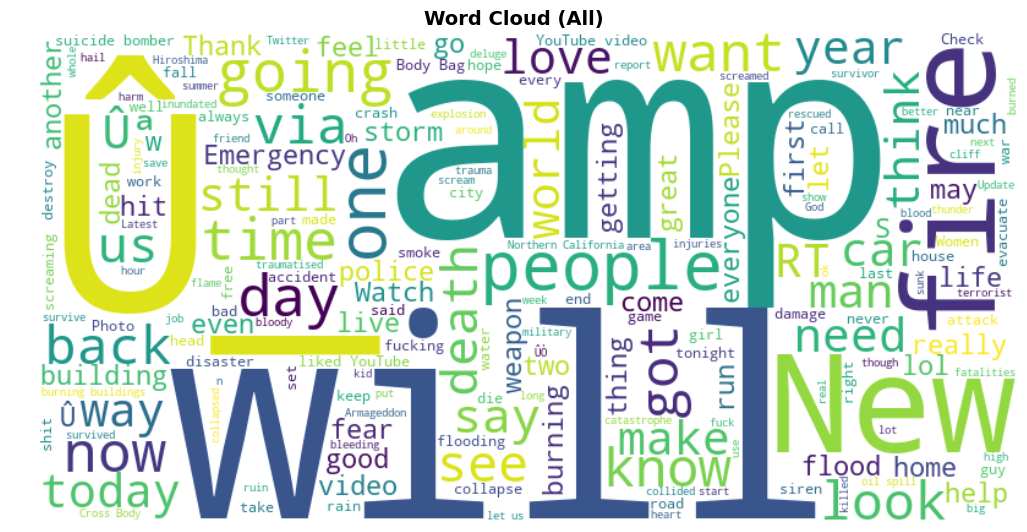

In [26]:
word_cloud_manager = WordCloudManager(train_df)
word_cloud_manager.display_word_cloud()

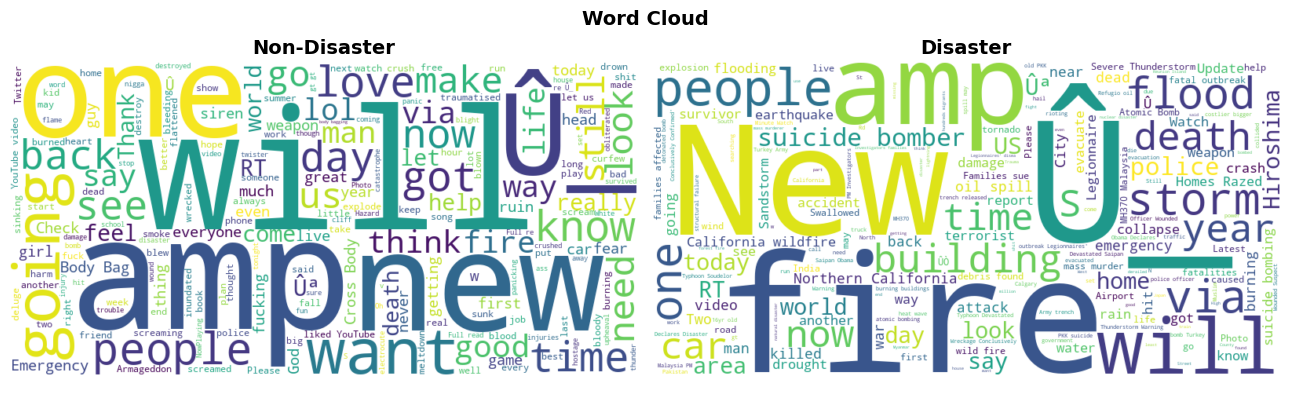

In [27]:
word_cloud_manager.display_word_cloud_by_classes()

From this we can see a couple things: First the words (and http patterns) have been removed. And second, with the 'Non-disaster' vs 'Disaster' clouds we can begin to see how these can be classified differently.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Tweet (Post) Statistics</span>

I want to display some more statistics on the data to get a better feel for what we are working with. This PostStatisticsManager class will handle the display of the typical min, max, mean, and standard deviation statistics as well as displaying histograms for both word length.

In [28]:
class PostStatisticsManager:
    """
    Manages the typical min, max, mean, and standard deviation statistics as well as displaying historgrams for word length.
    """
    def __init__(self, train_df):
        self.train_copy_df = train_df.copy()
        self.__build_data_frames(self.train_copy_df)

    def __build_data_frames(self, train_copy_df):
        train_copy_df['character_count'] = train_copy_df['text'].str.len()
        train_copy_df['word_count'] = train_copy_df['text'].apply(lambda x: len(x.split()))
        
    def __handle_statistics(self, column_name, target):
        series = self.train_copy_df.loc[self.train_copy_df['target'].isin(target)][column_name]
        series_data = {
            'minimum_length':np.min(series),
            'maximum_length':np.max(series),
            'mean':np.mean(series),
            'standard_deviation':np.std(series, ddof=1)
        }
        return pd.DataFrame.from_dict([series_data])

    def __handle_display_to_data_frames(self, df1, df2, main_title, title1, title2, color1, color2):
        display(HTML(f"""
            <div style="display: grid; grid-template-columns: repeat(1, 1fr); grid-template-rows: repeat(2, 0.5fr); gap: 10px;">
                <div style="text-align: center; font-size: 20px; font-weight: bold;">{main_title}</div>
                <div style="display: grid; grid-template-columns: repeat(2, 1fr); grid-template-rows: repeat(2, 0.5fr); gap: 10px;">
                    <div style="text-align: center; font-size: 20px; font-weight: bold;">{title1}</div>
                    <div style="text-align: center; font-size: 20px; font-weight: bold;">{title2}</div>
                    <div style="display: flex; justify-content: center; background-color: {color1};">{df1.round(2).to_html(index=False)}</div>
                    <div style="display: flex; justify-content: center; background-color: {color2};">{df2.round(2).to_html(index=False)}</div>
                </div>
            </div>
        """))

    def __handle_display_one_df(self, df, title, color):
        display(HTML(f"""
            <div style="display: grid; grid-template-columns: repeat(1, 1fr); grid-template-rows: repeat(2, 0.5fr); gap: 10px;">
                <div style="text-align: center; font-size: 20px; font-weight: bold;">{title}</div>
                <div style="display: flex; justify-content: center; background-color: {color};">{df.round(2).to_html(index=False)}</div>
            </div>
        """))
    def display_word_count_statistics(self):
        self.__handle_display_one_df(self.__handle_statistics('word_count',  [0,1]), 
                                     "Tweet/Post Word Count Statistics (All)",
                                    "#95c3c5")

    def display_character_count_statistics(self):
        self.__handle_display_one_df(self.__handle_statistics('character_count',  [0,1]),
                                     "Tweet/Post Character Count Statistics (All)",
                                     "#95c3c5")

    def display_word_count_statistics_by_class(self):
        negative_statistics_df = self.__handle_statistics('word_count',  [0])
        positive_statistics_df = self.__handle_statistics('word_count',  [1])

        self.__handle_display_to_data_frames(negative_statistics_df,
                                             positive_statistics_df, 
                                             "Tweet/Post Word Count Statistics by Class", 
                                             "Non-Disaster", 
                                             "Disaster",
                                             "#f4f5c5",
                                             "#bcd1fa")

    def display_character_count_statistics_by_class(self):
        negative_statistics_df = self.__handle_statistics('character_count',  [0])
        positive_statistics_df = self.__handle_statistics('character_count',  [1])

        self.__handle_display_to_data_frames(negative_statistics_df, 
                                             positive_statistics_df, 
                                             "Tweet/Post Character Count Statistics by Class", 
                                             "Non-Disaster", 
                                             "Disaster",
                                             "#f4f5c5",
                                             "#bcd1fa")

    def __handle_get_posts_with_min_number(self, column_name, num_posts, target):
        return self.train_copy_df.loc[self.train_copy_df['target'].isin(target)].sort_values(by=column_name, ascending=True).head(num_posts)

    def get_posts_with_min_number_of_characters(self, num_posts, target=[0, 1]):
        return  self.__handle_get_posts_with_min_number("character_count", num_posts, target)

    def get_posts_with_min_number_of_words(self, num_posts, target=[0, 1]):
        return  self.__handle_get_posts_with_min_number("word_count", num_posts, target)

    def __handle_get_text_lengths(self, target):
        return self.train_copy_df.loc[self.train_copy_df['target'].isin(target)]['text'].apply(lambda x: len(x.split()))
        
    def display_post_length_histogram(self):
        """
        Plot includes both non-disaster and disaster posts.
        """
        plt.figure(figsize=(13, 7))
        plt.hist(self.__handle_get_text_lengths([0,1]), bins=28, color="cadetblue", edgecolor="black")
        plt.title("Post Word Length Distribution (Both Disaster and Non-Disaster)", fontsize=TITLE_FONT_SIZE, fontweight='bold')
        plt.xlabel("Number of Words")
        plt.ylabel("Frequency")
        plt.show()

    def display_post_length_histogram_class_based(self):
        """
        Side-by-side plots of word length distribution histograms for non-disaster and disaster posts.
        """
        def add_histogram(current_ax, text_lengh_series, title, color):
            current_ax.hist(text_lengh_series, bins=28, color=color, edgecolor="black")
            current_ax.set_title(title)
            current_ax.set_xlabel("Number of Words")
            current_ax.set_ylabel("Frequency")
            
        negative_texts = self.__handle_get_text_lengths([0])
        positive_texts = self.__handle_get_text_lengths([1])

        figure, ax = plt.subplots(figsize=(13, 4))
        figure.suptitle("Post Word Length Distribution", fontsize=TITLE_FONT_SIZE, fontweight='bold')
        ax.axis('off')
        
        gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
        add_histogram(figure.add_subplot(gs[0]), negative_texts, "Non-Disaster", "gold")
        add_histogram(figure.add_subplot(gs[1]), positive_texts, "Disaster", "royalblue")

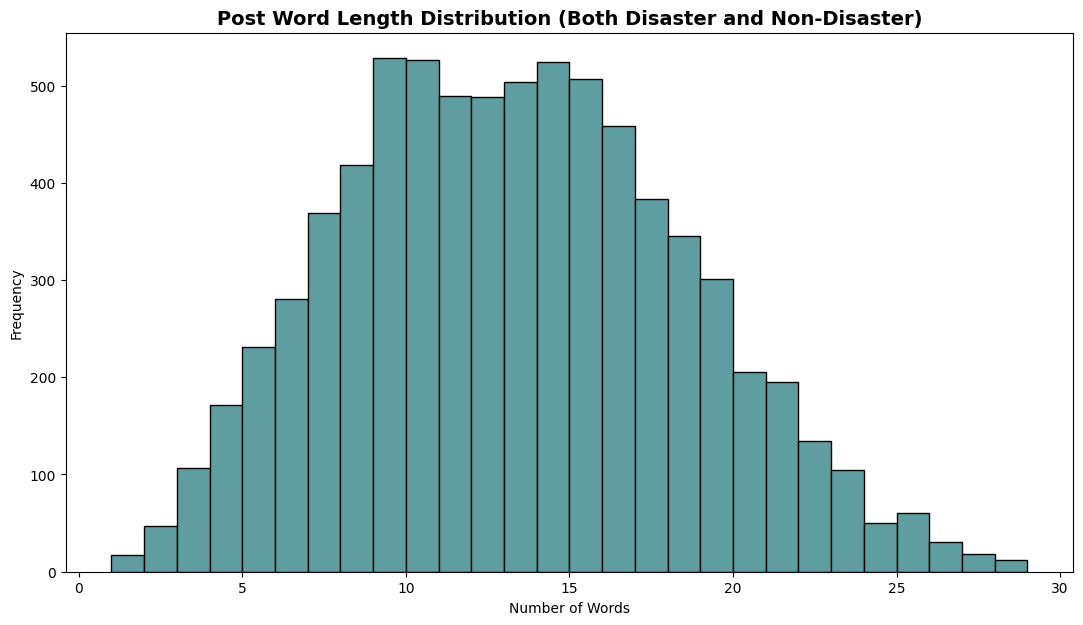

In [29]:
post_statistics_manager = PostStatisticsManager(train_df)
post_statistics_manager.display_post_length_histogram()

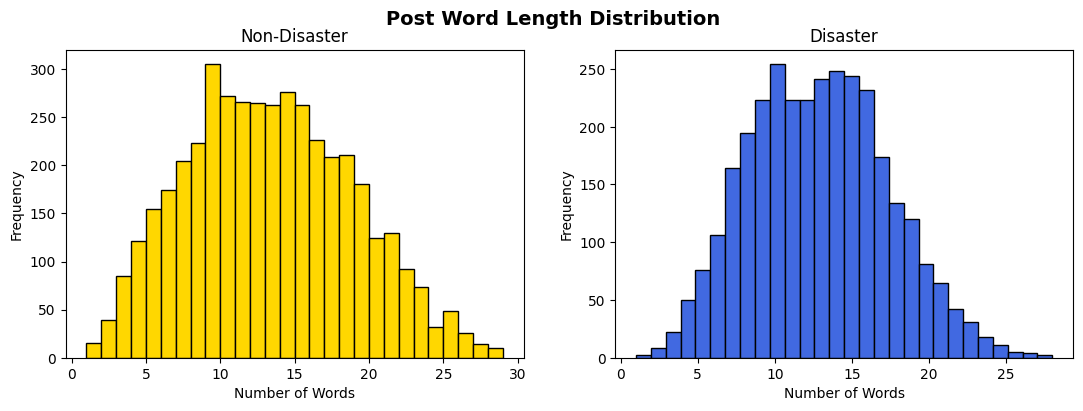

In [30]:
post_statistics_manager.display_post_length_histogram_class_based()

In [31]:
post_statistics_manager.display_word_count_statistics()
post_statistics_manager.display_word_count_statistics_by_class()
post_statistics_manager.display_character_count_statistics()
post_statistics_manager.display_character_count_statistics_by_class()

minimum_length,maximum_length,mean,standard_deviation
1,29,12.83,5.2


minimum_length,maximum_length,mean,standard_deviation
1,29,12.85,5.56
minimum_length,maximum_length,mean,standard_deviation
1,28,12.8,4.66


minimum_length,maximum_length,mean,standard_deviation
4,155,81.5,30.63


minimum_length,maximum_length,mean,standard_deviation
4,155,79.08,32.1
minimum_length,maximum_length,mean,standard_deviation
8,154,84.77,28.2


From these histograms and statistics, we can see that the post lengths are relatively consistent. With a relatively small standard deviation, it indicates most posts have similar lengths. 

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Class Distribution</span>

Next I will plot the distribution of non-disaster (0) and disaster (1) posts to see if there is an imbalance. A significant imbalance can cause bias in the model.

In [32]:
class ClassDistributionManager:
    def __init__(self, train_df):
        self.train_df = train_df

    def display_classification_counts(self, title):
        counts = self.train_df['target'].value_counts().sort_index()
        """
        Displays a pie chart and bar chart side-by-side for class data
        """
        def add_pie_chart():
            ax[0].pie(counts, labels=counts.index, autopct='%1.1f%%', textprops={'fontsize': DISPLAY_FONT_SIZE * 0.95},
                startangle=90, colors=['gold', 'dodgerblue'], wedgeprops={'edgecolor': 'black'})
    
        def add_bar_chart():
            bars = ax[1].bar(counts.index.astype(str), counts.values, width=0.5, color=['gold','dodgerblue'], edgecolor='black')
            ax[1].set_xlabel('Class', fontsize=DISPLAY_FONT_SIZE)
            ax[1].set_ylabel('Count', fontsize=DISPLAY_FONT_SIZE)
            ax[1].grid(axis='y', linestyle='solid', alpha=0.4)
    
            for bar in bars:
                ax[1].text(
                    bar.get_x() + bar.get_width() / 2.0, bar.get_height() / 2.0, f'{bar.get_height()}', ha='center',
                    fontsize=12, fontweight='regular', color='black')
        
        figure, ax = plt.subplots(1, 2, figsize=(13, 7), gridspec_kw={'width_ratios': [1, 1]})
        figure.suptitle(title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
    
        add_pie_chart()
        add_bar_chart()
        
        plt.tight_layout()
        plt.show()

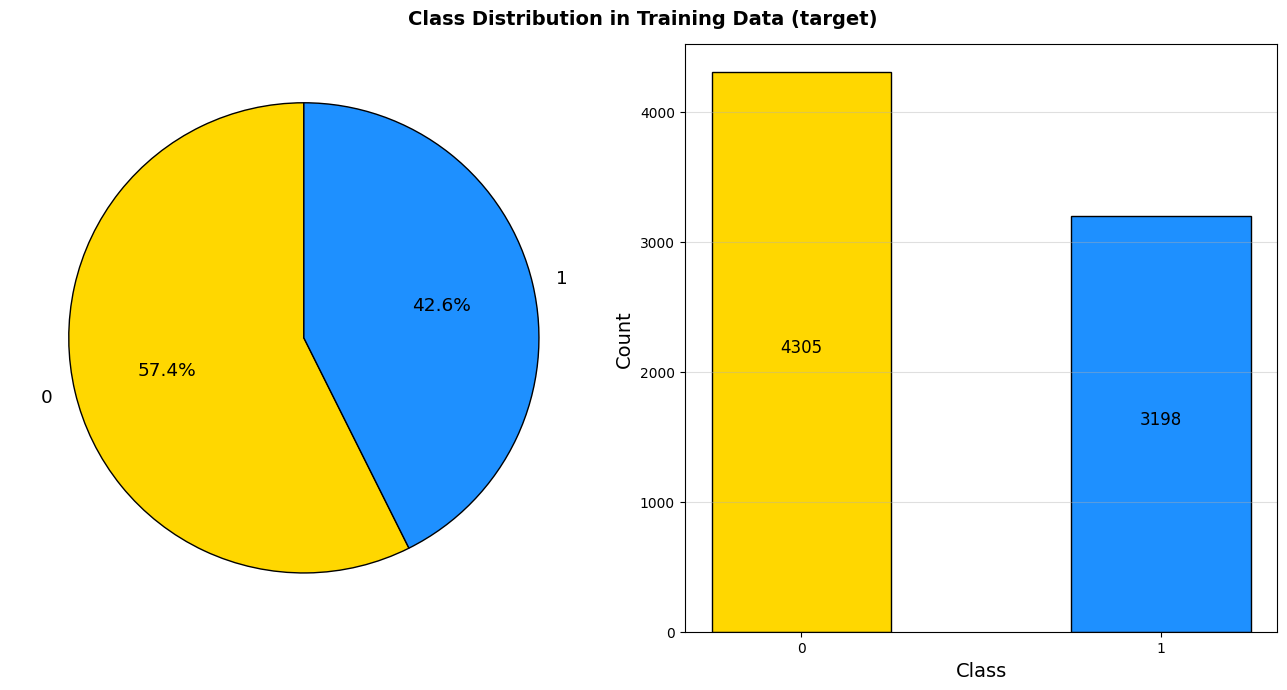

In [33]:
class_distribution_manager = ClassDistributionManager(train_df)
class_distribution_manager.display_classification_counts(f'Class Distribution in Training Data (target)')

The data isn't terribly imbalanced, with a slight preference for non-disaster Tweets/Posts. I'll keep an eye on this and make any model adjustments that are necessary.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">EDA and Data Cleaning Summary and Discussion</span>

* I first started out by removing the unused "keyword" and "location" columns. Since those won't be used in the training of the model, it makes sense to remove them.
* After removing those unused columns, I checked for any missing data and none was found.
* The 'text' column was of type 'object'. Pandas recommends to use 'StringDType' for text, so I converted it to that.
* I checked for duplicate text entries and found over 100 duplicates. Duplicates can cause overfitting of the model, inflating the training accuracy value, bias towards text, and increase computational time. So I removed those duplicate rows. This does slightly shrink an already small dataset somewhat.
* The word-frequency histograms helped me identify a number of words to remove from the text data. A big one was the shorthand URL pattern to Twitter (now X). Looking at the histogram plots between the non-disaster and disaster posts, I removed several words that might slow the model training process. Common words that occur in both classifications can lead to confusion in the model training process.
* With some text statistics (min, max, mean, sd, and distribution plots) it was discovered that the Tweet/Post lengths are trending towards a consistent length. This should help the training process.
* Finally I looked at the class (non-disaster and disaster) distribution. I found there is a little imbalance favoring the non-disaster class. It's not a huge imbalance, but perhaps will be worth looking into with the model architecture.

From the EDA and data cleanup steps, I am ready to use what I learned to design the model architecture for this project.

## <span style="color: royalblue;">Model Architecture</span>

From the instructions, it was mentioned that there are many ways to process text to matrix form. With this project, I'm going to stick with **Tensorflow's Tokenizer** that I used in the EDA portion of this project. I plan to use Keras libraries for the neural network portion of the assignment, so it makes sense that the text preprocessing to also be handled by Tensorflow libraries. If this presents a problem, I'll switch to something like **Word2Vec**. Basically all a tokenizer does is to transform the words index positions. These index positions can't be used directly with a neural network as the index values could mislead the model (e.g. an index of 2 could be perceived as twice as important as an index of 1). To address this, an embedding layer is used. This transforms the tokenizer's indices into dense vectors that better reflect the relationship between the words. Keras has an **Embedding** layer I will use for this step.

In the introduction, I mentioned I wanted to try out a vanilla **SimpleRNN** first then try a more sophisticated architecture like **GRU**. I will first do a number of iterations on a Keras **SimpleRNN** trying to improve the accuracy, then I will switch to a Keras **GRU** architecture to see how that can affect the accuracy.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Train/Validation Split</span>

In order to effectively train the model, we need to split the data into training and validation sets. This is typically an 80/20 split. I will experiment with this. With the small dataset, I worry there won't be enough training data.

In [34]:
class DataTokenizerManager:
    """
    This class will take care of converting the text to padded sequences
    """
    def __init__(self, train_df, test_df, num_words, padding_max_length, test_size):
        # Create the train/val split
        X_train, X_val, y_train, y_val = train_test_split(train_df['text'], train_df['target'], test_size=test_size, random_state=SEED_VALUE)

        # Test doesn't need a split. It also doesn't have a target value (as that is what we will be predicting).
        X_test = test_df['text']

        # Not going to specify an OOV (out of vocabulary) token. If a word is not in the vocabulary, it won't be tokenized.
        self.tokenizer = Tokenizer(num_words=num_words)

        # Only going to fit on training data (not validation) so that the model can learn to generalize on unseen data.
        self.tokenizer.fit_on_texts(X_train)

        # Create the sequences (these will need to be padded to make a consistent input).
        X_train = self.tokenizer.texts_to_sequences(X_train)
        X_val = self.tokenizer.texts_to_sequences(X_val)
        X_test = self.tokenizer.texts_to_sequences(X_test)
        
        # From the EDA, it was determined that the max text length was 28 words. However, the process of tokenization might change that value.
        post = "post"
        # padding=post: zeros go at the end.
        # truncating=post: truncating at the end.
        X_train = pad_sequences(X_train, maxlen=padding_max_length, padding=post, truncating=post)
        X_val = pad_sequences(X_val, maxlen=padding_max_length, padding=post, truncating=post)
        X_test = pad_sequences(X_test, maxlen=padding_max_length, padding=post, truncating=post)

        # These will be used for fitting the model.
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

        # This will be used to test how well the model has generalized (using Kaggle to obtain the score).
        self.X_test = X_test

In [35]:
class AccuracyResults:
    """
    Handles the display of the resulting accuracy and AUC plots.
    """

    def __init__(self, model, title):
        self.model = model
        self.title=title

    def display_accuracy_plots(self):
        def add_plot(current_ax, val1_key, val2_key, label1, label2, y_label, title):
            val1 = self.model.results.history[val1_key]
            epoch_list = list(range(1, len(val1) + 1))
            current_ax.plot(epoch_list, val1, linestyle='dashed', color='magenta', label=label1)
            current_ax.plot(epoch_list, self.model.results.history[val2_key], linestyle='solid', color='blue', label=label2)
            if len(epoch_list) <= 18:
                current_ax.set_xticks(epoch_list)
            current_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            current_ax.set_xlabel('Epoch')
            current_ax.set_ylabel(y_label)
            current_ax.set_title(title)
            current_ax.legend()

        figure, ax = plt.subplots(figsize=(13, 4))
        figure.suptitle(self.title, fontsize=TITLE_FONT_SIZE, fontweight='bold')
        ax.axis('off')
        
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0, 1])

        add_plot(figure.add_subplot(gs[0]), 
                 'accuracy', 
                 'val_accuracy', 
                 'Train Accuracy', 
                 'Validation Accuracy', 
                 'Accuracy', 
                 'Train and Validation Accuracy')

        add_plot(figure.add_subplot(gs[2]), 
                 'loss', 
                 'val_loss', 
                 'Train Loss', 
                 'Validation Loss', 
                 'Loss', 
                 'Train and Validation Loss')

        plt.tight_layout()
        plt.show()

    def display_auc_plot(self):
        auc = self.model.results.history['auc']
        epoch_list = list(range(1, len(auc) + 1))
        plt.figure(figsize=(11,5))
        plt.plot(epoch_list, auc, linestyle='dashed', color='magenta', label='Train AUC')
        plt.plot(epoch_list, self.model.results.history['val_auc'], linestyle='solid', color='blue', label='Validation AUC')
        if len(epoch_list) <= 19:
            plt.xticks(epoch_list)
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.title('Train and Validation AUC')
        plt.legend()
        plt.show()

In [36]:
class F1ScoreContainer:
    """
    Container for F1 scores
    """
    def __init__(self, model_name, value):
        self.model_name = model_name
        self.value = value

class F1ScoreComparisonManager:
    """
    Manages the F1 scores for both validation and test data.
    """
    def __init__(self):
        self.validation_list = []
        self.test_list = []

    def add_validation_record(self, f1_score_container):
        self.validation_list.append(f1_score_container)

    def add_test_record(self, f1_score_container):
        self.test_list.append(f1_score_container)

    def display_results(self):
        """
        Plots the validation F1 scores and test F1 scores
        """
        model_names = [f1_score_container.model_name for f1_score_container in self.validation_list]
        validation_f1_scores = [f1_score_container.value for f1_score_container in self.validation_list]
        test_f1_scores = [f1_score_container.value for f1_score_container in self.test_list]

        figure, ax = plt.subplots(figsize=(12, 9))
        figure.suptitle("Validation F1 vs Test F1", fontsize=TITLE_FONT_SIZE, fontweight='bold')
        ax.axis('off')

        gs = gridspec.GridSpec(2, 1)

        ax0 = figure.add_subplot(gs[0, 0])
        ax1 = figure.add_subplot(gs[1, 0])

        ax0.plot(model_names, validation_f1_scores, linestyle='dashed', label="Validation F1", color="blue")
        ax0.plot(model_names, test_f1_scores, linestyle='solid', label="Test F1", color="green")

        ax0.set_xlabel("Models")
        ax0.set_ylabel("F1 Score")
        ax0.legend()

        ax1.axis('off')
        self.__add_legend(ax1)

        plt.subplots_adjust(hspace=0.2)
        plt.tight_layout()
        plt.show()

    def __add_legend(self, ax):
        """
        Legend to understand model name abreviations
        """
        legend_dictionary = {'simple_rnn': 'Basic baseline RNN',
                             'reg_simple_rnn': 'Regularized basic RNN',
                             'reg_lstm': 'Regularized LSTM',
                             'reg_gru': 'Regularized GRU',
                             'bidirectional_reg_gru': 'Bidirectional Regularized GRU',
                             'bidirectional_reg_gru_w_cw': 'Bidirectional Regularized GRU with Class Weight Balancing'
                            }
        legend_df = pd.DataFrame(list(legend_dictionary.items()), columns=["Model", "Description"])

        # Creating a table to display the data frame
        table = ax.table(cellText=legend_df.values, colLabels=legend_df.columns, cellLoc="left", loc="center")
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.auto_set_column_width([0,1])
        [row.set_height(0.07) for row in table.get_celld().values()]

In [37]:
# Creating an instance of F1ScoreComparisonManager to add F1 scores for the various models as well as the Kaggle test data values
f1_score_comparison_manager = F1ScoreComparisonManager()

In [38]:
class ClassificationAndConfusionMatrixManager:
    """
    Manages the display of the classification report and confusion matrix
    """
    def __init__(self, fit_model, model_tokenizer_manager):
        self.model = fit_model
        self.model_tokenizer_manager = model_tokenizer_manager
        self.classification_report_df = None
        
    def display(self):
        figure, ax = plt.subplots(figsize=(11, 5))
        ax.axis('off')
        
        figure.suptitle("Classification Report and Confusion Matrix", fontsize=TITLE_FONT_SIZE, fontweight='bold')

        gs = gridspec.GridSpec(1,3, width_ratios=[1, 0, 1])
        ax0 = figure.add_subplot(gs[0])
        ax1 = figure.add_subplot(gs[2])

        ax0.axis('tight')
        ax0.axis('off')

        # using the fit model to predict labels. The cutoff for a postive outcome is 0.5 (which is typical)
        y_pred = (self.model.predict(self.model_tokenizer_manager.X_val) > 0.5).astype(int)

        # Using SKLearn metric library
        classification_report_df = pd.DataFrame(classification_report(self.model_tokenizer_manager.y_val, y_pred, output_dict=True, digits=4)).transpose()
        self.classification_report_df = classification_report_df

        # Creating a table to display the classification report data frame
        table = ax0.table(cellText=classification_report_df.round(4).values,
                            colLabels=classification_report_df.columns,
                            rowLabels=classification_report_df.index,
                            cellLoc='center',
                            loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.1, 1.1)

        cm = confusion_matrix(self.model_tokenizer_manager.y_val, y_pred)
        confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        confusion_matrix_display.plot(ax=ax1, cmap='Purples', values_format='d')
        ax1.set_title('Confusion Matrix')

        plt.tight_layout()
        plt.show()

    def record_f1_score(self, f1_score_comparison_manager, model_name):
        f1_score_comparison_manager.add_validation_record(F1ScoreContainer(model_name, self.classification_report_df.loc['macro avg', 'f1-score']))
                                                                           

In [39]:
class TestDataPredictionManager:
    """
    Manages predicting the labels and saving the results to a file to be uploaded to Kaggle
    """
    def __init__(self, fitted_model, filename, data_tokenizer_manager, test_data_df):
        self.model = fitted_model
        self.filename = filename
        self.data_tokenizer_manager = data_tokenizer_manager
        self.test_data_df = test_data_df

    def predict_and_save(self):
        y_pred = (self.model.predict(self.data_tokenizer_manager.X_test) >= 0.5).astype(int)

        test_results_df = pd.DataFrame({
            'id': self.test_data_df['id'],
            'target': y_pred.flatten()
        })

        # Save files in the results directory
        os.makedirs('results', exist_ok=True)
        test_results_df.to_csv(os.path.join('results',f'{self.filename}.csv'), index=False)

In [40]:
class AbstractRNNBaseModel(ABC):
    """
    Handles the common classes for the model training (fitting)
    """
    def __init__(self, data_tokenizer_manager, max_epochs, batch_size, early_stopping_patience, class_weight=None):
        self.data_tokenizer_manager = data_tokenizer_manager
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.early_stopping_patience = early_stopping_patience
        self.class_weight = class_weight
        self.model = None
        self.results = None
        
    @abstractmethod
    def build_model(self):
        # Override in subclass
        pass

    def fit_model(self):
        """
        Sets the callback, class weight, and trains the model.
        """
        self.model = self.build_model()

        # All models will use early stopping when the validation loss starts to get worse.
        early_stopping = EarlyStopping(monitor='val_loss', patience=self.early_stopping_patience, restore_best_weights=True)

        # Fit the model and return the history
        self.results = self.model.fit(self.data_tokenizer_manager.X_train, 
                          self.data_tokenizer_manager.y_train, 
                          validation_data=(self.data_tokenizer_manager.X_val, self.data_tokenizer_manager.y_val), 
                          epochs=self.max_epochs, batch_size=self.batch_size, callbacks=[early_stopping], class_weight=self.class_weight)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Some shared hyperparameters:</span>

In [41]:
# Tokenizer settings
num_words = 5000 # Limiting the vocabulary size
padding_max_length = 28 # From the EDA, we saw the max text length was 28
test_size_percent = 0.18 #Trying to balance out keeping enough data for training yet have meaningful validation metrics

# Model settings
max_epochs = 20 # With early stopping, this number probaly won't be reached.
batch_size = 32 # Smaller batch size to indroduce a little "noise"

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Simple RNN</span>

This is the first model I will try out. It will be a baseline of sorts. The vanilla RNN has issues with long-term time dependencies and exploding and vanishing gradients. Given small nature of the text we are working with, it might not be a significant problem, but it is something to watch out for.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

This basic RNN will have an embedding layer, the simple RNN layer, and a dense output layer. Because this is a binary classification, a sigmoid activation is used. A modified Adam optimizer is in place and a traditional binary cross entropy loss function in used.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

The number of words used in the tokenizer is set to 5000. This will limit the vocabulary size to the 5000 most frequent words when creating the sequences, the rest will be ignored.

The max length for padding the sequences is set to the maximum lenth of a text (as determined in the EDA section).

Because the dataset is small in terms of both examples and the length of those examples, I want to try to keep the number of parameters on the lower end. To do this, I will set the embedding layer to 50 and the SimpleRNN neuron count to 32. A larger model might be able to learn more complex relationships, but there just isn't enough data to justify a larger model here.

I have the batch size set to 32 which seems like an acceptable size. The lower the batch size, the more noise introduced in the training which could help with overfitting.

I set the epoch size to a maximum of 20, but with early stopping being used, that is unlikely to be reached.

In [42]:
class SimpleRNNModel(AbstractRNNBaseModel):
    """
    Starting point model
    """
    def __init__(self, model_tokenizer_manager, padding_max_length, max_epochs, batch_size, early_stopping_patience):
        super().__init__(model_tokenizer_manager, max_epochs, batch_size, early_stopping_patience)
        self.padding_max_length = padding_max_length

    # Override
    def build_model(self):
        model = Sequential()

        # The embedding layer transforms the tokenizer's indices into dense vectors.
        model.add(Embedding(input_dim=num_words, output_dim=50, input_length=self.padding_max_length))
        # Adding a vanilla RNN layer
        model.add(SimpleRNN(32, kernel_initializer=Orthogonal(seed=SEED_VALUE+1)))#return_sequences=True
        # Output layer using a sigmoid activation for the binary classification
        model.add(Dense(1, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), activation='sigmoid')) # Sigmoid is used for binary classification
        # Clipping to 1 in Adam optimizer to prevent exploding gradients
        model.compile(optimizer=Adam(clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy', AUC()])

        return model

In [43]:
simple_rnn_name = 'simple_rnn'

This tokenizer will be used for all the model variations:

In [44]:
data_tokenizer_manager =  DataTokenizerManager(train_df, test_df, num_words, padding_max_length, test_size_percent)

Train the model:

In [45]:
tf.keras.backend.clear_session()
simple_rnn_model = SimpleRNNModel(data_tokenizer_manager, padding_max_length, max_epochs, batch_size, 3)
simple_rnn_model.fit_model()

Epoch 1/20
193/193 [==============================] - 12s 49ms/step - loss: 0.5841 - accuracy: 0.6951 - auc: 0.7425 - val_loss: 0.5432 - val_accuracy: 0.7432 - val_auc: 0.7960
Epoch 2/20
193/193 [==============================] - 10s 51ms/step - loss: 0.3734 - accuracy: 0.8514 - auc: 0.9054 - val_loss: 0.5365 - val_accuracy: 0.7639 - val_auc: 0.8022
Epoch 3/20
193/193 [==============================] - 10s 53ms/step - loss: 0.2547 - accuracy: 0.9085 - auc: 0.9538 - val_loss: 0.5568 - val_accuracy: 0.7506 - val_auc: 0.8068
Epoch 4/20
193/193 [==============================] - 11s 57ms/step - loss: 0.1668 - accuracy: 0.9436 - auc: 0.9810 - val_loss: 0.6233 - val_accuracy: 0.7550 - val_auc: 0.8013
Epoch 5/20
193/193 [==============================] - 11s 56ms/step - loss: 0.1160 - accuracy: 0.9620 - auc: 0.9907 - val_loss: 0.6842 - val_accuracy: 0.7557 - val_auc: 0.8094


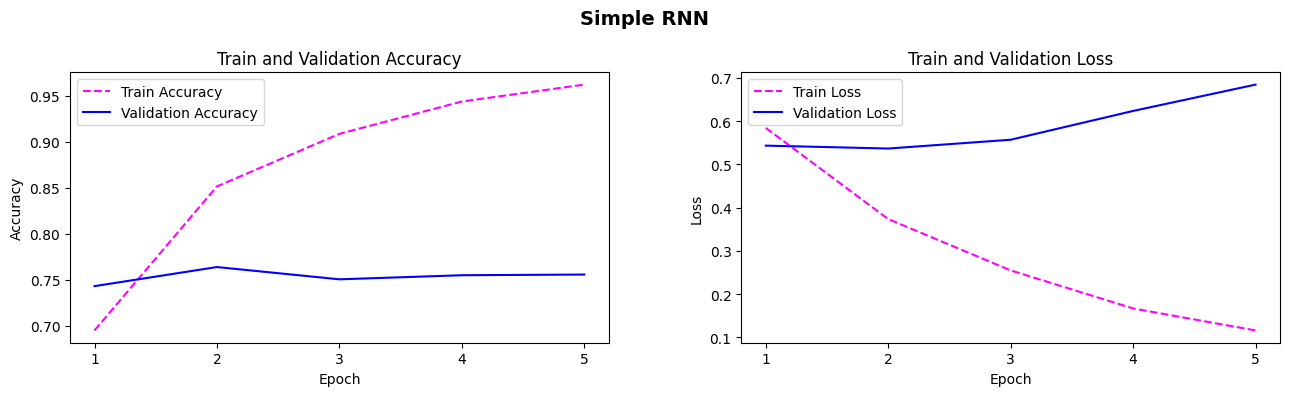

In [46]:
accuracy_results = AccuracyResults(simple_rnn_model, 'Simple RNN')
accuracy_results.display_accuracy_plots()

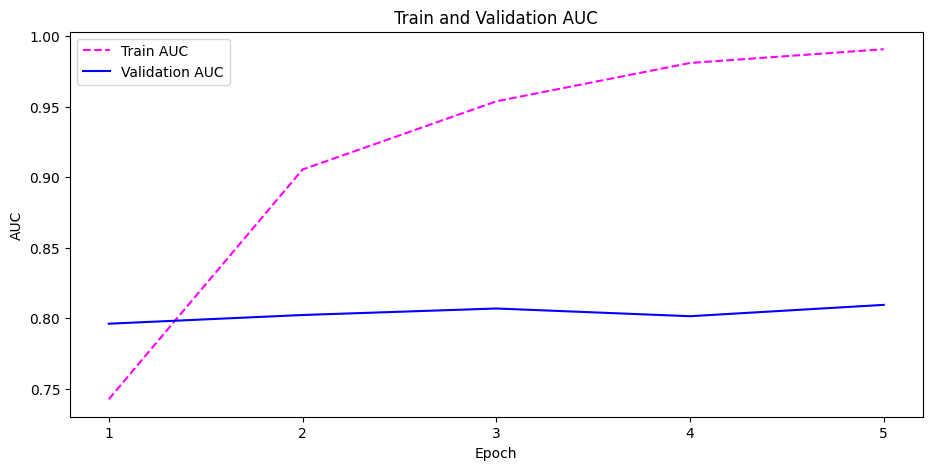

In [47]:
accuracy_results.display_auc_plot()

This first model fitting shows very clearly that the model is overfitting. The train accuracy keeps rising reaching a maximum of over 0.98 at the same time the validation accuracy drops off after only reaching a maximum of under 0.8.

The AUC plot shows a similar pattern. The training value is approaching 1 (which is the ideal maximum here) while the validation data struggles to reach 0.85. While the validation value is not terrible, generally we want this value to be closer to 1. This value indicates how well the model is handling both classes.

43/43 [==============================] - 1s 11ms/step


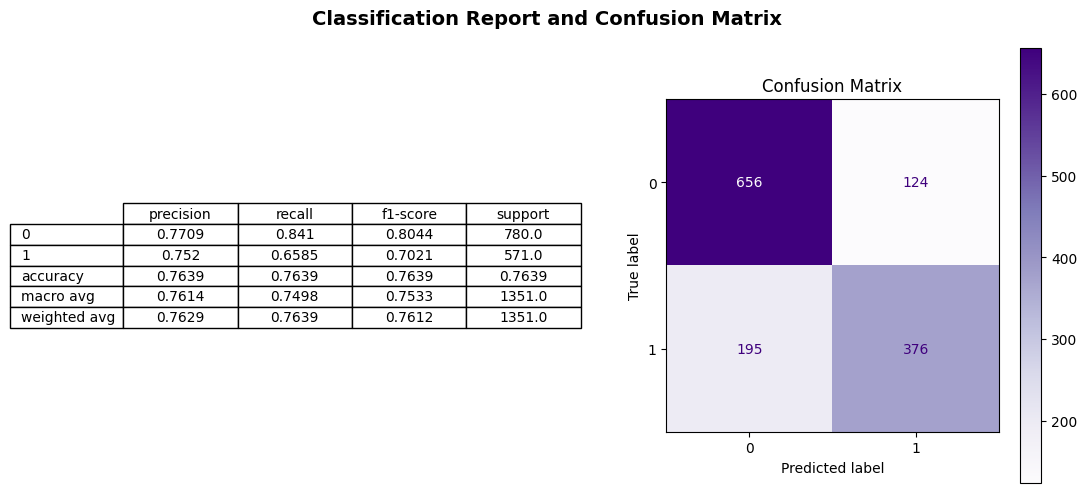

In [48]:
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(simple_rnn_model.model, data_tokenizer_manager)
classification_and_confusion_matrix_manager.display()

The precision, recall, and f1 seem to match the accuracy, that is, it's not terrible, but could be better. There is definitely an imbalance here, suggesting that the class distribution imbalance might be playing a role.

The confusion matrix shows a number of false positives and false negatives. There are more false negatives, which is likely again influenced by the class imbalance. It's also likely that the "disaster" tweet indicators aren't very influential to help the model know when to predict them.

In [49]:
# Adding the F1 score to be used for the results at the end of the notebook
classification_and_confusion_matrix_manager.record_f1_score(f1_score_comparison_manager, simple_rnn_name)

In [50]:
# Using the fitted model to predict values for the test data (and saving the file to be uploaded to Kaggle)
test_prediction_manager = TestDataPredictionManager(simple_rnn_model.model, simple_rnn_name, data_tokenizer_manager, test_df)
test_prediction_manager.predict_and_save()

102/102 [==============================] - 1s 10ms/step


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Regularized Simple RNN</span>

From the last step, it is very clear the model is overfitting the data. In this step I will add regularization techniques to try to address that.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

I will add dropout layers after both the embedding and RNN layers. I will also add L2 regularization to the RNN layer as well as the output dense layer.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

I won't change the vocabulary size, batch size, or padding max length here. I will set the dropout layers to a decently influential number of 0.5. I will set the L2 value to a conservative number in the RNN layer and a slightly more aggressive number in the output layer. In addition to the dropout layers, I will set the RNN's dropout argument to a fairly conservative value of 0.3.

In [51]:
class RegularizedSimpleRNN(AbstractRNNBaseModel):
    """
    Simple RNN with regularization
    """
    def __init__(self, model_tokenizer_manager, padding_max_length, max_epochs, batch_size, early_stopping_patience):
        super().__init__(model_tokenizer_manager, max_epochs, batch_size, early_stopping_patience)
        self.padding_max_length = padding_max_length
    
    # Override
    def build_model(self):
        model = Sequential()

        # The embedding layer transforms the tokenizer's indices into dense vectors.
        model.add(Embedding(input_dim=num_words, output_dim=50, input_length=self.padding_max_length))
        model.add(Dropout(0.5))
        # Adding a vanilla RNN layer
        model.add(SimpleRNN(32, 
                            kernel_initializer=Orthogonal(seed=SEED_VALUE+1), 
                            kernel_regularizer=regularizers.L2(1e-4), 
                            dropout=0.3, 
                            recurrent_dropout=0))
        model.add(Dropout(0.5))
        # Output layer using a sigmoid activation for the binary classification
        model.add(Dense(1, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(1e-3), activation='sigmoid'))

        # Clipping any gradients above 1.
        model.compile(optimizer=Adam(clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy', AUC()])
    
        return model

In [52]:
reg_simple_rnn_name = "reg_simple_rnn"

In [53]:
tf.keras.backend.clear_session()
reg_simple_rnn_model = RegularizedSimpleRNN(data_tokenizer_manager, padding_max_length, max_epochs, batch_size, 3)
reg_simple_rnn_model.fit_model()

Epoch 1/20
193/193 [==============================] - 14s 65ms/step - loss: 0.6361 - accuracy: 0.6504 - auc: 0.6763 - val_loss: 0.5294 - val_accuracy: 0.7705 - val_auc: 0.7972
Epoch 2/20
193/193 [==============================] - 13s 68ms/step - loss: 0.4882 - accuracy: 0.7986 - auc: 0.8329 - val_loss: 0.4839 - val_accuracy: 0.8016 - val_auc: 0.8376
Epoch 3/20
193/193 [==============================] - 14s 70ms/step - loss: 0.4203 - accuracy: 0.8404 - auc: 0.8756 - val_loss: 0.5165 - val_accuracy: 0.7772 - val_auc: 0.8339
Epoch 4/20
193/193 [==============================] - 13s 66ms/step - loss: 0.3684 - accuracy: 0.8589 - auc: 0.9080 - val_loss: 0.4971 - val_accuracy: 0.7861 - val_auc: 0.8398
Epoch 5/20
193/193 [==============================] - 13s 66ms/step - loss: 0.3196 - accuracy: 0.8846 - auc: 0.9297 - val_loss: 0.5018 - val_accuracy: 0.7898 - val_auc: 0.8388


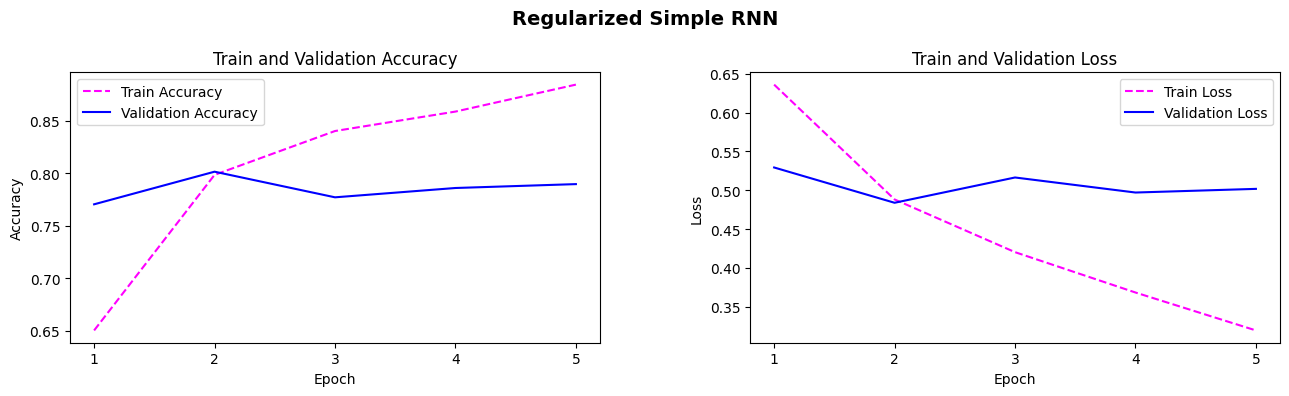

In [54]:
accuracy_results = AccuracyResults(reg_simple_rnn_model, 'Regularized Simple RNN')
accuracy_results.display_accuracy_plots()

This looks a little better, but the model is still overfitting. The simple RNN model is pretty basic so it might be hard to tune out all the overfitting. The validation accuracy didn't drop off like it did in the non-regularized model. It just sort of plateaued early on. 

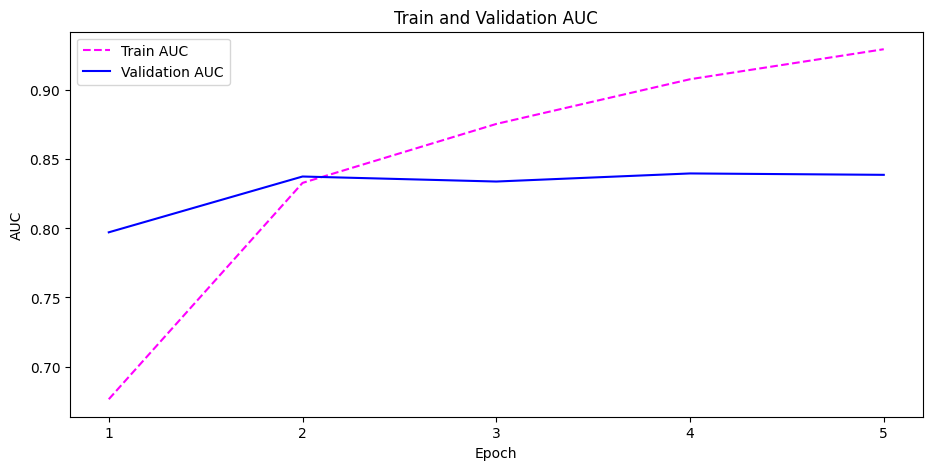

In [55]:
accuracy_results.display_auc_plot()

The AUC curve also looks a little better than base line. It shows that the regularization had a positive effect. The overfitting isn't quite as dramatic as the previous example.

43/43 [==============================] - 1s 11ms/step


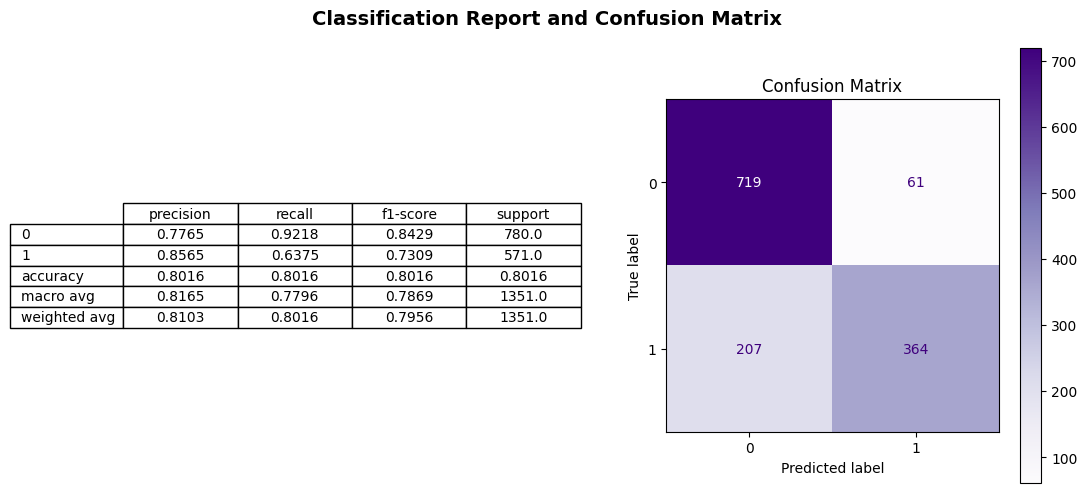

In [56]:
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(reg_simple_rnn_model.model, data_tokenizer_manager)
classification_and_confusion_matrix_manager.display()

The precision, recall, and f1 scores looks slightly better this time around indicating it's doing a better job at properly classifying the data.

The confusion matrix is showing reduced false positives. This is a step in the right direction.

In [57]:
# Adding the F1 score to be used for the results at the end of the notebook:
classification_and_confusion_matrix_manager.record_f1_score(f1_score_comparison_manager, reg_simple_rnn_name)

In [58]:
# Using the fitted model to predict values for the test data (and saving the file to be uploaded to Kaggle)
test_prediction_manager = TestDataPredictionManager(reg_simple_rnn_model.model, reg_simple_rnn_name, data_tokenizer_manager, test_df)
test_prediction_manager.predict_and_save()

102/102 [==============================] - 1s 11ms/step


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Regularized LSTM</span>

Rather than continue to tweak the simple RNN model, I will move onto an improved version known as the LSTM. This model has better time dependency retention and improved handling of any vanishing or exploding gradients. The one downside is it is a bit complex. With the increased complexity comes an increased number of learnable parameters that can influence overfitting the data. Because of this, I will immediately include some regularization with the model.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

With this model I am keeping the same general design as the regularized simple RNN, but using a LSTM layer in place of the SimpleRNN layer. The design is the same though. That is an embedding layer, a dropout layer, a LSTM layer, followed by another dropout layer and finished with a dense output layer.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

Because an LSTM is more complex than a simple RNN, there are more parameters to train. With more parameters and such a small amount of data, I increased the L2 regularization on the LSTM layer.

In [59]:
class RegularizedLSTM(AbstractRNNBaseModel):
    """
    Basic RNN with regularization
    """
    def __init__(self, model_tokenizer_manager, padding_max_length, max_epochs, batch_size, early_stopping_patience):
        super().__init__(model_tokenizer_manager, max_epochs, batch_size, early_stopping_patience)
        self.padding_max_length = padding_max_length
    
    # Override
    def build_model(self):
        model = Sequential()
    
        # The embedding layer transforms the tokenizer's indices into dense vectors.
        model.add(Embedding(input_dim=num_words, output_dim=50, input_length=self.padding_max_length))
        model.add(Dropout(0.5))
        # Adding a LSTM layer
        model.add(LSTM(32, 
                            kernel_initializer=Orthogonal(seed=SEED_VALUE+1), 
                            kernel_regularizer=regularizers.L2(1e-3), 
                            dropout=0.3, 
                            recurrent_dropout=0))
        model.add(Dropout(0.5))
        # Output layer using a sigmoid activation for the binary classification
        model.add(Dense(1, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(1e-3), activation='sigmoid'))
    
        # Clipping to 1 in Adam optimizer to prevent exploding gradients
        model.compile(optimizer=Adam(clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy', AUC()])
    
        return model

In [60]:
reg_lstm_name = "reg_lstm"

In [61]:
tf.keras.backend.clear_session()
reg_lstm_model = RegularizedLSTM(data_tokenizer_manager, padding_max_length, max_epochs, batch_size, 3)
reg_lstm_model.fit_model()

Epoch 1/20
193/193 [==============================] - 8s 29ms/step - loss: 0.6369 - accuracy: 0.6591 - auc: 0.6866 - val_loss: 0.5113 - val_accuracy: 0.7713 - val_auc: 0.8506
Epoch 2/20
193/193 [==============================] - 5s 25ms/step - loss: 0.4308 - accuracy: 0.8272 - auc: 0.8716 - val_loss: 0.4459 - val_accuracy: 0.8083 - val_auc: 0.8622
Epoch 3/20
193/193 [==============================] - 5s 26ms/step - loss: 0.3698 - accuracy: 0.8568 - auc: 0.9075 - val_loss: 0.4501 - val_accuracy: 0.8009 - val_auc: 0.8627
Epoch 4/20
193/193 [==============================] - 5s 26ms/step - loss: 0.3235 - accuracy: 0.8823 - auc: 0.9300 - val_loss: 0.4638 - val_accuracy: 0.8075 - val_auc: 0.8609
Epoch 5/20
193/193 [==============================] - 5s 26ms/step - loss: 0.2929 - accuracy: 0.8887 - auc: 0.9420 - val_loss: 0.4547 - val_accuracy: 0.8113 - val_auc: 0.8592


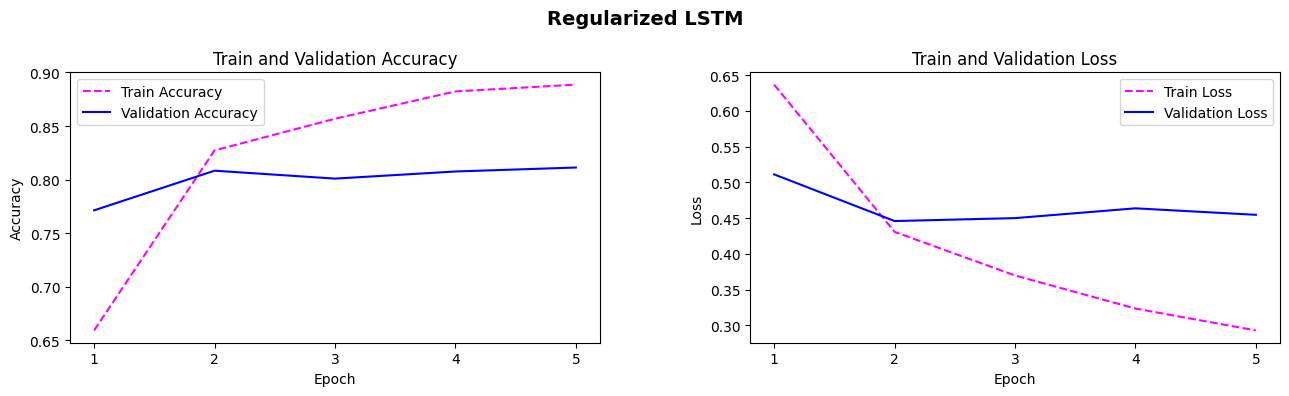

In [62]:
accuracy_results = AccuracyResults(reg_lstm_model, 'Regularized LSTM')
accuracy_results.display_accuracy_plots()

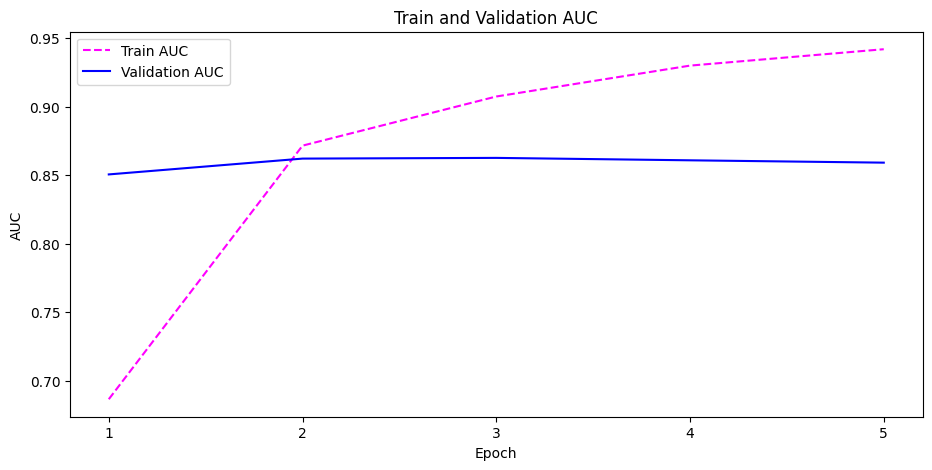

In [63]:
accuracy_results.display_auc_plot()

The accuracy curves don't look that different from the regularized simple RNN, but the loss plot does look a bit better. The AUC plot looks very similar to the previous plot but looking closely the validation values are a bit higher. Which is good.

43/43 [==============================] - 1s 11ms/step


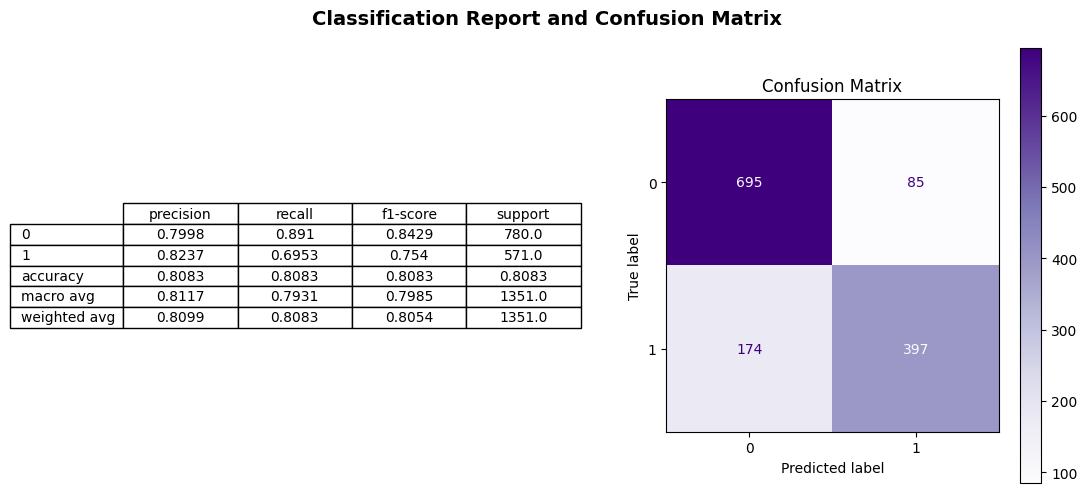

In [64]:
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(reg_lstm_model.model, data_tokenizer_manager)
classification_and_confusion_matrix_manager.display()

The recall is imbalanced. The f1 score is slightly better. There is a reduction in false negatives.

In [65]:
# Recording the F1 score:
classification_and_confusion_matrix_manager.record_f1_score(f1_score_comparison_manager, reg_lstm_name)

In [66]:
# Use the fitted model on the test data
test_prediction_manager = TestDataPredictionManager(reg_lstm_model.model, reg_lstm_name, data_tokenizer_manager, test_df)
test_prediction_manager.predict_and_save()

102/102 [==============================] - 1s 7ms/step


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Regularized GRU</span>

This model adds regularization to the GRU model. The GRU model, being less complex than the LSTM, has less parameters which is already is a form a regularization (less parameters mean lowering the ability for a model to overfit), but as we have seen in previous model training sessions here, the models tend to overfit the data. So adding any additional regularization will hopefully help.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

This model will use an embedding layer, a dropout layer, a GRU layer, another dropout layer, followed by a dense layer. Typical binary cross entropy loss is used. A modified Adam optimizer with clipping enabled. GRUs are less likely to experience exploding gradients, but it's good to make sure it doesn't happen.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

The GRU layer will use L2 regularization with a value of 1e-4. It will also use dropout set to 0.3. I have the recurrent_dropout set to 0 otherwise the settings don't meet the criteria to use cuDNN libraries with my GPU. I have two additional Dropout layers with the one after the Embedding layer set to 0.4 and the one after the GRU set to 0.5. The dense layer also uses L2 regularization with a value set to 1e-3. Optimizer clipping is again set with a value of 1.0.

In [67]:
class RegularizedGRU(AbstractRNNBaseModel):
    """
    Basic RNN with regularization
    """
    def __init__(self, model_tokenizer_manager, padding_max_length, max_epochs, batch_size, early_stopping_patience):
        super().__init__(model_tokenizer_manager, max_epochs, batch_size, early_stopping_patience)
        self.padding_max_length = padding_max_length
    
    # Override
    def build_model(self):
        model = Sequential()
    
        # The embedding layer transforms the tokenizer's indices into dense vectors.
        model.add(Embedding(input_dim=num_words, output_dim=50, input_length=self.padding_max_length))
        model.add(Dropout(0.4))
        # Adding a GRU layer
        model.add(GRU(32, 
                            kernel_initializer=Orthogonal(seed=SEED_VALUE+1), 
                            kernel_regularizer=regularizers.L2(1e-4), 
                            dropout=0.3, 
                            recurrent_dropout=0))
        model.add(Dropout(0.5))
        # Output layer using a sigmoid activation for the binary classification
        model.add(Dense(1, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), kernel_regularizer=regularizers.L2(1e-3), activation='sigmoid'))
    
        # Clipping to 1 in Adam optimizer to prevent exploding gradients
        model.compile(optimizer=Adam(clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy', AUC()])
    
        return model

In [68]:
reg_gru_name = "reg_gru"

Train the model:

In [69]:
tf.keras.backend.clear_session()
reg_gru_model = RegularizedGRU(data_tokenizer_manager, padding_max_length, max_epochs, batch_size, 3)
reg_gru_model.fit_model()

Epoch 1/20
193/193 [==============================] - 7s 28ms/step - loss: 0.6884 - accuracy: 0.5694 - auc: 0.4846 - val_loss: 0.6836 - val_accuracy: 0.5774 - val_auc: 0.4929
Epoch 2/20
193/193 [==============================] - 4s 22ms/step - loss: 0.6865 - accuracy: 0.5730 - auc: 0.4789 - val_loss: 0.6835 - val_accuracy: 0.5774 - val_auc: 0.5020
Epoch 3/20
193/193 [==============================] - 4s 22ms/step - loss: 0.6845 - accuracy: 0.5730 - auc: 0.5032 - val_loss: 0.6825 - val_accuracy: 0.5774 - val_auc: 0.5086
Epoch 4/20
193/193 [==============================] - 5s 23ms/step - loss: 0.5912 - accuracy: 0.6783 - auc: 0.7227 - val_loss: 0.4906 - val_accuracy: 0.7698 - val_auc: 0.8461
Epoch 5/20
193/193 [==============================] - 4s 23ms/step - loss: 0.4111 - accuracy: 0.8319 - auc: 0.8819 - val_loss: 0.4483 - val_accuracy: 0.8016 - val_auc: 0.8558
Epoch 6/20
193/193 [==============================] - 4s 22ms/step - loss: 0.3407 - accuracy: 0.8680 - auc: 0.9199 - val_loss

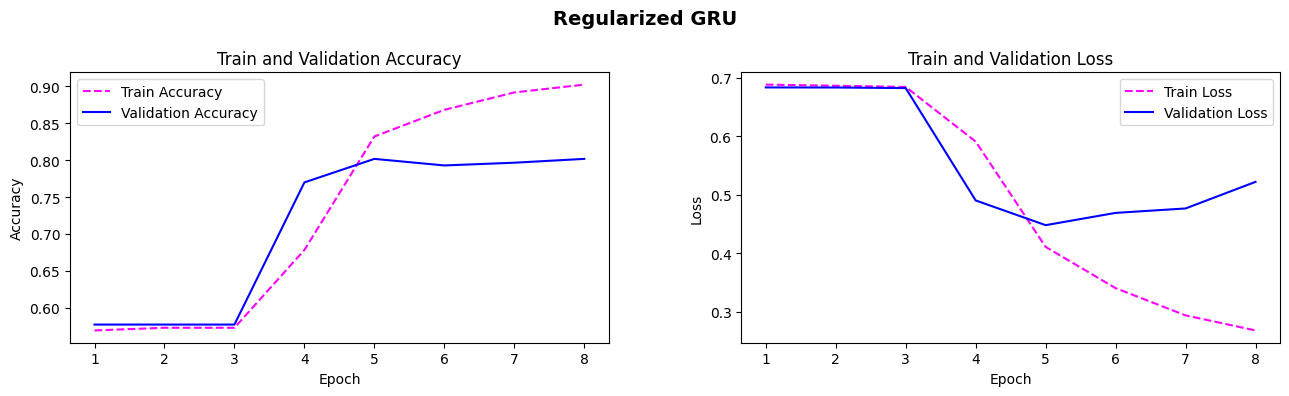

In [70]:
accuracy_results = AccuracyResults(reg_gru_model, 'Regularized GRU')
accuracy_results.display_accuracy_plots()

The validation accuracy plot looks to follow the shape of the training plot better, however the validation loss plot seems the retract a bit.

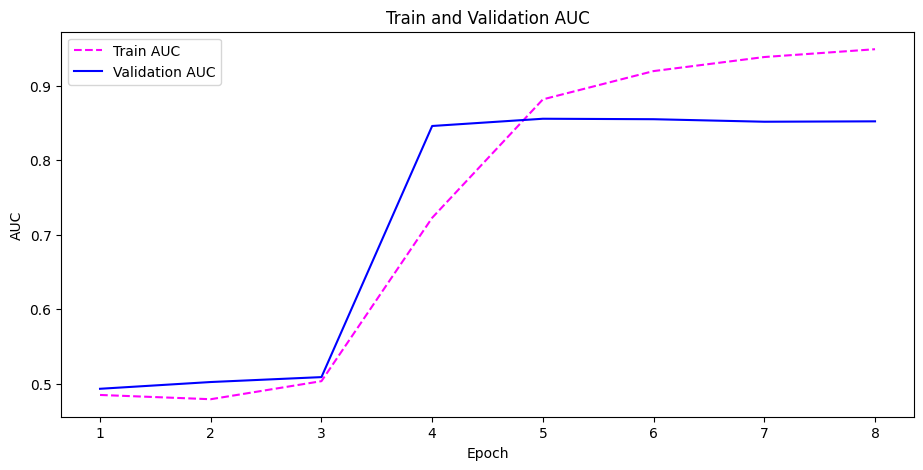

In [71]:
accuracy_results.display_auc_plot()

The AUC curve for the validation data also follows the training curve pretty decently. The value remains at a decent level.

43/43 [==============================] - 1s 9ms/step


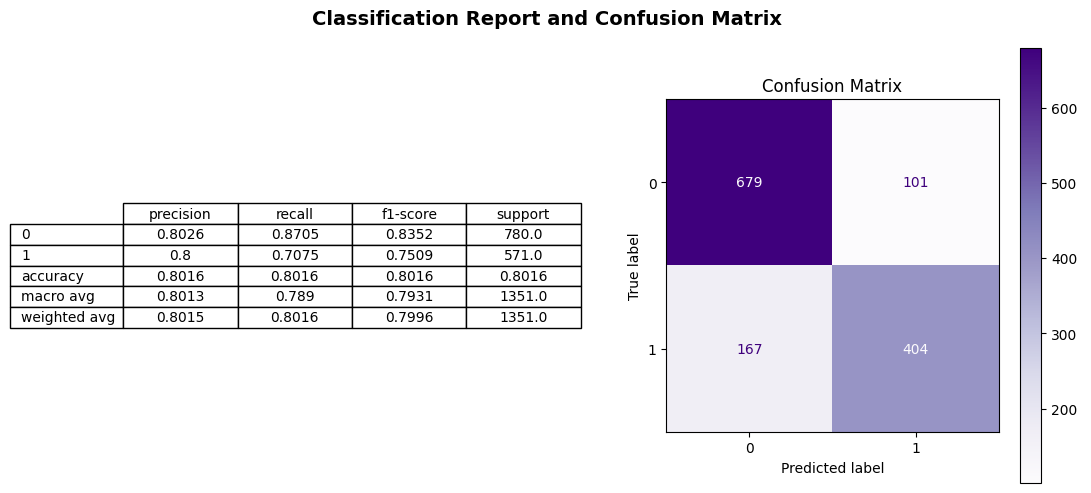

In [72]:
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(reg_gru_model.model, data_tokenizer_manager)
classification_and_confusion_matrix_manager.display()

The classification report is showing the familiar imbalance between the positive and negative classes. The confusion matrix is also showing the imbalance between the false positives and false negatives. This is reflected in the classification report.

In [73]:
# Recording the F1 score
classification_and_confusion_matrix_manager.record_f1_score(f1_score_comparison_manager, reg_gru_name)

In [74]:
# Using the fitted model on the test data to make predictions
test_prediction_manager = TestDataPredictionManager(reg_gru_model.model, reg_gru_name, data_tokenizer_manager, test_df)
test_prediction_manager.predict_and_save()

102/102 [==============================] - 1s 6ms/step


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Bidirectional Regularized GRU</span>

I will now add a bidirectional component to the regularized GRU model. This will allow the sequences to be processed in both directions. This can potentially uncover additional meaning if the a particular word or group of words gets context from surrounding words.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

The notable change here is the additional of the bidirectional support added to the GRU layer. I also added L1 regularization for the first time to the GRU and dense layers. This is because of the increased complexity introduced with the bidirectional support to address the overfitting we are seeing at the end of the training cycles.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

Because of the bidirectional nature, the I increased the amount of L2 regularization in the GRU layer. I also reduced the dropout layers' value slightly because with the introduction of the L1 regularization on the GRU and dense layers, I didn't want too much regularization. The number of words in the vocabulary, the max length for the padding, and batch size remain the same.

In [75]:
class RegularizedBidirectionalGRU(AbstractRNNBaseModel):
    """
    Basic RNN with regularization
    """
    def __init__(self, model_tokenizer_manager, padding_max_length, max_epochs, batch_size, early_stopping_patience, class_weight=None):
        super().__init__(model_tokenizer_manager, max_epochs, batch_size, early_stopping_patience, class_weight)
        self.padding_max_length = padding_max_length
    
    # Override
    def build_model(self):
        model = Sequential()
    
        # The embedding layer transforms the tokenizer's indices into dense vectors.
        model.add(Embedding(input_dim=num_words, output_dim=45, input_length=self.padding_max_length))
        model.add(Dropout(0.49))
        # Adding a bidirectional GRU layer
        model.add(Bidirectional(GRU(30, 
                            kernel_initializer=Orthogonal(seed=SEED_VALUE+1), 
                            kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                            dropout=0.5, 
                            recurrent_dropout=0)))
        model.add(Dropout(0.49))
        # Output layer using a sigmoid activation for the binary classification
        model.add(Dense(1, kernel_initializer=Orthogonal(seed=SEED_VALUE+2), 
                        kernel_regularizer=regularizers.L1L2(l1=1e-3, l2=1e-3), 
                        activation='sigmoid'))
    
        # Clipping to 1 in Adam optimizer to prevent exploding gradients
        model.compile(optimizer=Adam(clipvalue=1.0), loss='binary_crossentropy', metrics=['accuracy', AUC()])
    
        return model

In [76]:
bidirectional_reg_gru_name = "bidirectional_reg_gru"

Train the model:

In [77]:
tf.keras.backend.clear_session()
reg_bidirectional_gru_model = RegularizedBidirectionalGRU(data_tokenizer_manager, padding_max_length, max_epochs, batch_size, 3)
reg_bidirectional_gru_model.fit_model()

Epoch 1/20
193/193 [==============================] - 10s 37ms/step - loss: 0.9611 - accuracy: 0.5717 - auc: 0.5322 - val_loss: 0.7161 - val_accuracy: 0.5774 - val_auc: 0.7977
Epoch 2/20
193/193 [==============================] - 7s 34ms/step - loss: 0.6034 - accuracy: 0.7224 - auc: 0.7919 - val_loss: 0.5095 - val_accuracy: 0.7942 - val_auc: 0.8488
Epoch 3/20
193/193 [==============================] - 6s 31ms/step - loss: 0.4578 - accuracy: 0.8231 - auc: 0.8802 - val_loss: 0.4896 - val_accuracy: 0.8038 - val_auc: 0.8518
Epoch 4/20
193/193 [==============================] - 6s 31ms/step - loss: 0.4083 - accuracy: 0.8474 - auc: 0.9054 - val_loss: 0.4786 - val_accuracy: 0.8031 - val_auc: 0.8559
Epoch 5/20
193/193 [==============================] - 6s 30ms/step - loss: 0.3698 - accuracy: 0.8690 - auc: 0.9247 - val_loss: 0.4876 - val_accuracy: 0.8001 - val_auc: 0.8537
Epoch 6/20
193/193 [==============================] - 6s 32ms/step - loss: 0.3468 - accuracy: 0.8761 - auc: 0.9346 - val_los

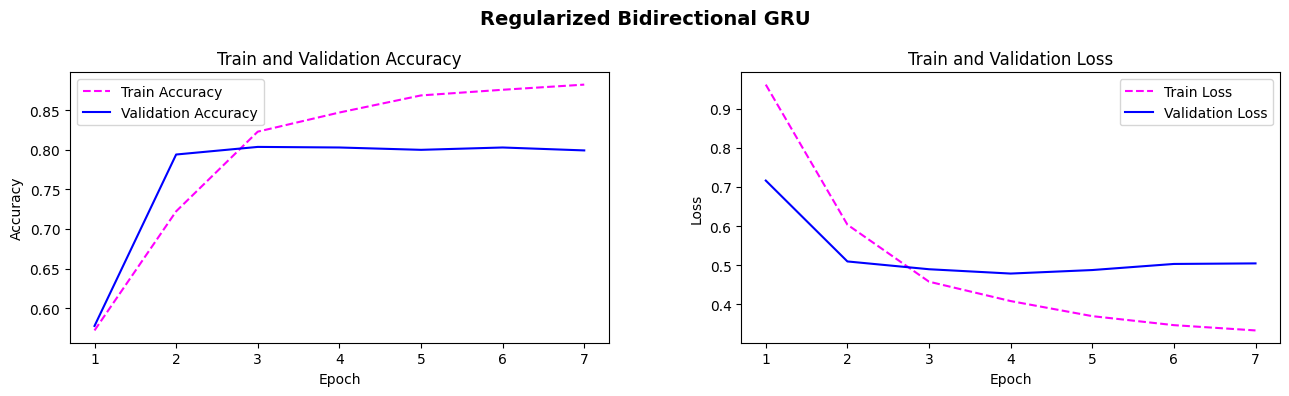

In [78]:
accuracy_results = AccuracyResults(reg_bidirectional_gru_model, 'Regularized Bidirectional GRU')
accuracy_results.display_accuracy_plots()

Both the accuracy plots look pretty good. The validation curve matches the train plots better and the overfitting is better than some of the previous models.

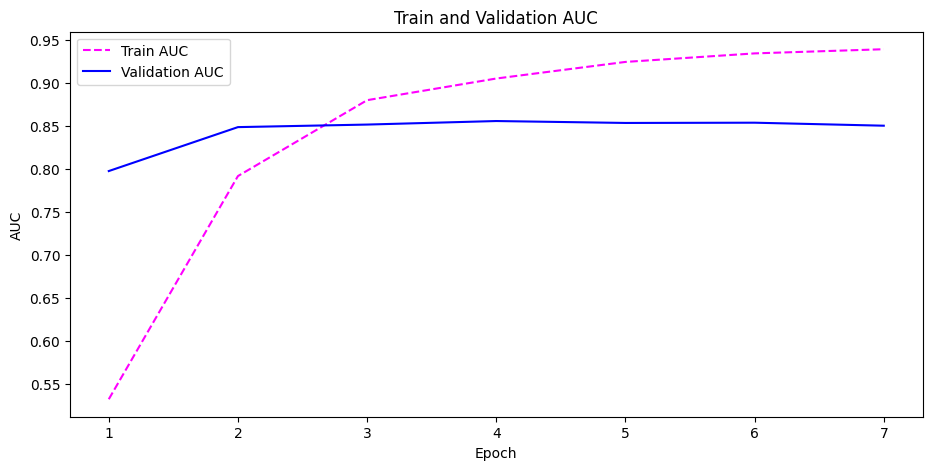

In [79]:
accuracy_results.display_auc_plot()

The AUC value for validation data remains steady. There a bit of overtraining apparent.

43/43 [==============================] - 1s 17ms/step


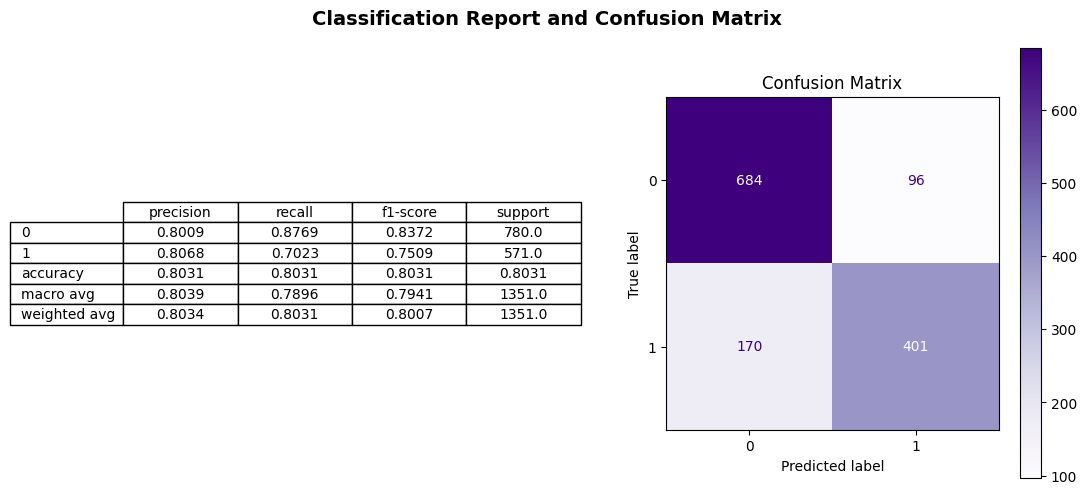

In [80]:
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(reg_bidirectional_gru_model.model, data_tokenizer_manager)
classification_and_confusion_matrix_manager.display()

The precision, recall, and f1 all follow the values seen with the accuracy plots. The confusion matrix still shows a bias towards the negative case with a lower amount of false positives compared to the higher amount of false negatives.

In [81]:
# Recording the F1 score
classification_and_confusion_matrix_manager.record_f1_score(f1_score_comparison_manager, bidirectional_reg_gru_name)

In [82]:
# Using the fitted model on the test data to get predictions to submit to Kaggle
test_prediction_manager = TestDataPredictionManager(reg_bidirectional_gru_model.model, bidirectional_reg_gru_name, data_tokenizer_manager, test_df)
test_prediction_manager.predict_and_save()

102/102 [==============================] - 1s 8ms/step


<span style="font-size: 17px; font-weight: bold; color: royalblue;">Adding Class Weight</span>

From the EDA section, we discovered that there was a target imbalance favoring non-disaster tweets/posts. The imbalance isn't substantial but with such a small amount of training data (and the texts themselves being short), it might have some effect on the training an predictions. I'm going to add a penalty to mistakes made based on the class distribution to see how that will affect the outcome.

In [83]:
class ClassWeightManager:
    def __init__(self, train_df):
        self.train_df = train_df

    def create_class_weight(self):
        labels = self.train_df['target'].to_numpy()

        # Sklearn util
        class_weights = compute_class_weight('balanced', classes=np.array([0,1]), y=labels)

        return dict(enumerate(class_weights))

In [84]:
class_weight_manager = ClassWeightManager(train_df)

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Bidirectional Regularized GRU with Class Weight Balancing</span>

I will reuse the same regularized bidirectional GRU model but add class weight balancing. As discussed above, class weight balancing adds a penalty to the mistakes proportional to the target value distribution.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Architecture Highlights</span>

The only change to this model is when it is being fit with the addition of the class weight (see the ClassWeightManager class above).

<span style="font-size: 14px; font-weight: bold; color: royalblue;">Hyperparameter Tuning Highlights</span>

The hyperparameter values remain the same as the above bidirectional regularized GRU model. The number of words in the vocabulary, the max length for the padding, and batch size remain the same.

Train the model (using a class weight argument):

In [85]:
bidirectional_reg_gru_w_cw_name = "bidirectional_reg_gru_w_cw"

In [86]:
tf.keras.backend.clear_session()
bidirectional_reg_gru_model_with_class_weight = RegularizedBidirectionalGRU(data_tokenizer_manager, 
                                                          padding_max_length, 
                                                          max_epochs, batch_size, 
                                                          3, 
                                                          class_weight_manager.create_class_weight())
bidirectional_reg_gru_model_with_class_weight.fit_model()

Epoch 1/20
193/193 [==============================] - 11s 37ms/step - loss: 0.9702 - accuracy: 0.5156 - auc: 0.5369 - val_loss: 0.7298 - val_accuracy: 0.7439 - val_auc: 0.5990
Epoch 2/20
193/193 [==============================] - 6s 32ms/step - loss: 0.6667 - accuracy: 0.6201 - auc: 0.6764 - val_loss: 0.5232 - val_accuracy: 0.7654 - val_auc: 0.8327
Epoch 3/20
193/193 [==============================] - 7s 36ms/step - loss: 0.4824 - accuracy: 0.8124 - auc: 0.8676 - val_loss: 0.5009 - val_accuracy: 0.7942 - val_auc: 0.8463
Epoch 4/20
193/193 [==============================] - 6s 32ms/step - loss: 0.4280 - accuracy: 0.8428 - auc: 0.8976 - val_loss: 0.4758 - val_accuracy: 0.8083 - val_auc: 0.8558
Epoch 5/20
193/193 [==============================] - 6s 32ms/step - loss: 0.3885 - accuracy: 0.8600 - auc: 0.9184 - val_loss: 0.4909 - val_accuracy: 0.7935 - val_auc: 0.8515
Epoch 6/20
193/193 [==============================] - 6s 33ms/step - loss: 0.3611 - accuracy: 0.8760 - auc: 0.9308 - val_los

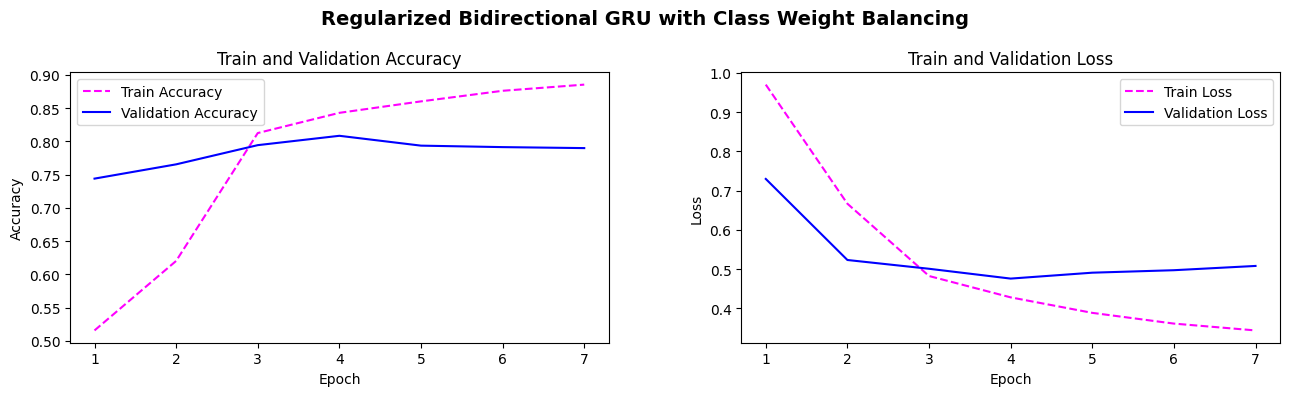

In [87]:
accuracy_results = AccuracyResults(bidirectional_reg_gru_model_with_class_weight, 'Regularized Bidirectional GRU with Class Weight Balancing')
accuracy_results.display_accuracy_plots()

The validation accuracy curve remained steady. Because of the early stopping, the model stopped training when there was a consistent increase in the loss value. This is meant to help with the overfitting as continued training would likely lead to increased overfitting and a reduction in the model's ability to generalize on unseen data.

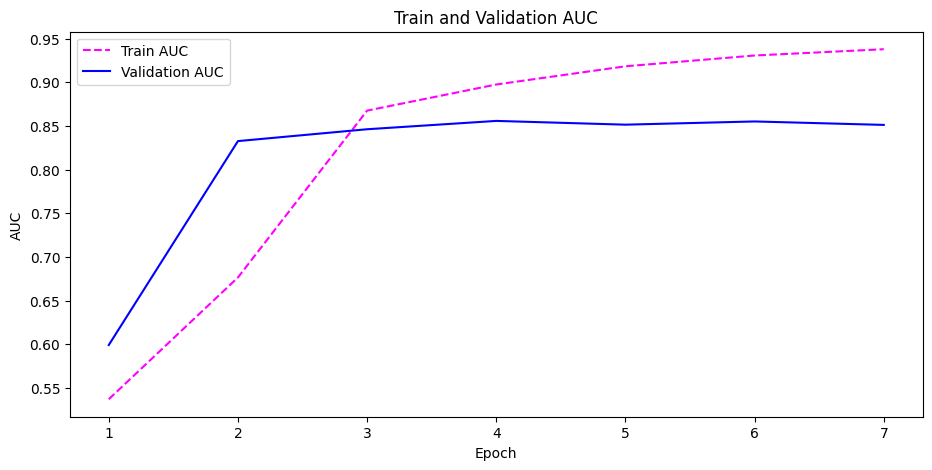

In [88]:
accuracy_results.display_auc_plot()

The AUC curve for the validation data quickly levels off suggesting no improvement in classification after the early epochs. There is a bit of overfitting evident as well.

43/43 [==============================] - 1s 12ms/step


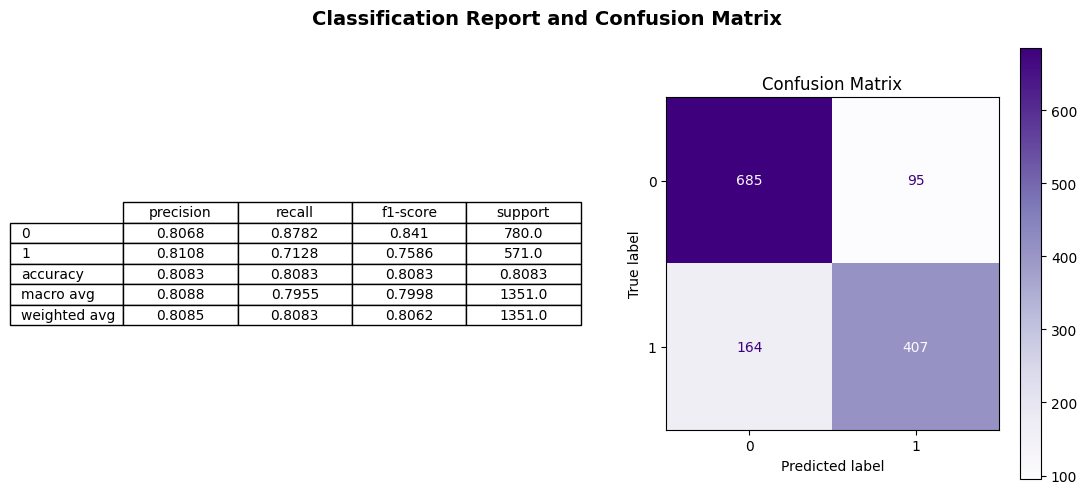

In [89]:
classification_and_confusion_matrix_manager = ClassificationAndConfusionMatrixManager(bidirectional_reg_gru_model_with_class_weight.model, data_tokenizer_manager)
classification_and_confusion_matrix_manager.display()

The classification report is showing some fairly consistent and decent values for precision. There is an imbalance in  the recall. The confusion matrix is showing an improvement in false negatives. Perhaps the class weight balancing had a positive effect.

In [90]:
# Recording the F1 score
classification_and_confusion_matrix_manager.record_f1_score(f1_score_comparison_manager, bidirectional_reg_gru_w_cw_name)

In [91]:
# Using the fitted model on the test data to get predictions to submit to Kaggle
test_prediction_manager = TestDataPredictionManager(bidirectional_reg_gru_model_with_class_weight.model, bidirectional_reg_gru_w_cw_name, data_tokenizer_manager, test_df)
test_prediction_manager.predict_and_save()

102/102 [==============================] - 1s 8ms/step


## <span style="color: royalblue;">Results (Combined)</span>

Below I will plot the validation data F1 scores for all the models along with the test data F1 scores retrieved from Kaggle.

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Kaggle Submission Screenshot</span>









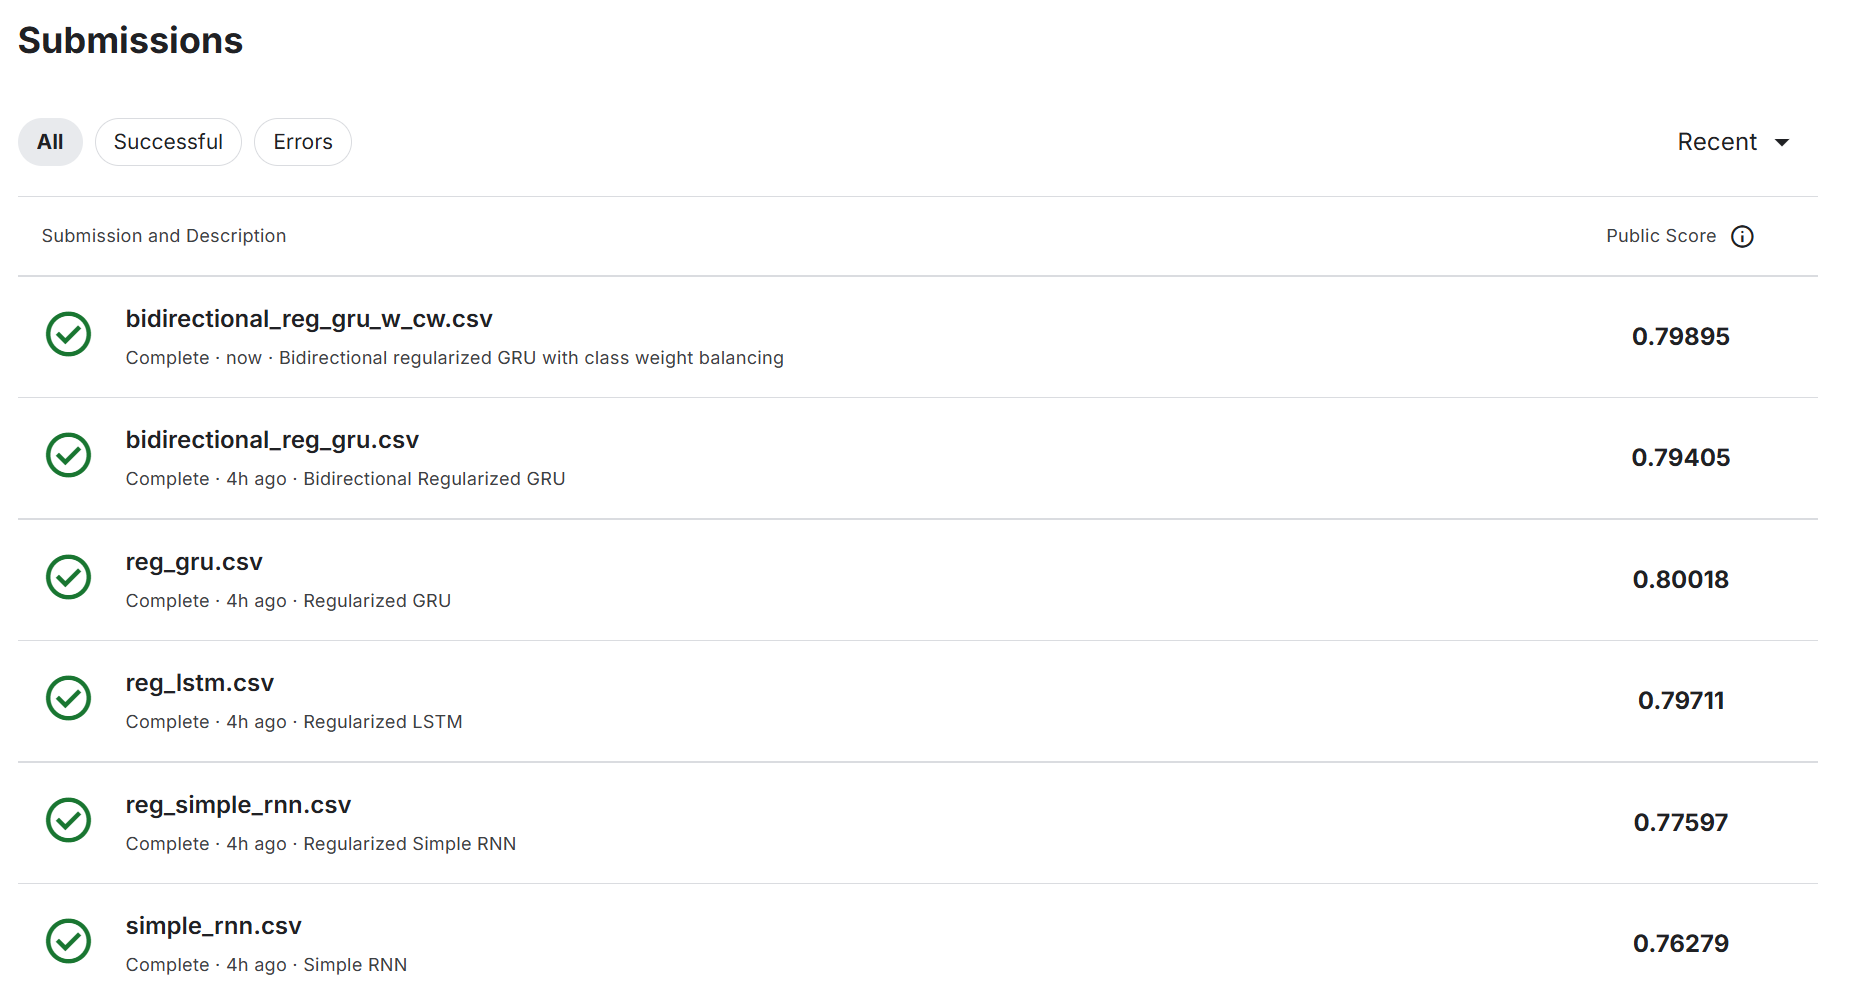

<span style="font-size: 17px; font-weight: bold; color: royalblue;">Kaggle Leaderboard Position Screenshot</span>


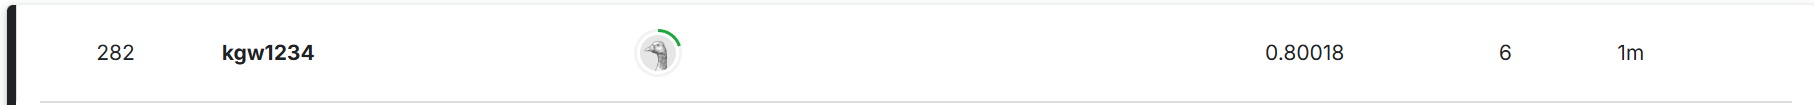






My regularized GRU model performed the best on Kaggle. I was thinking it was going to the bidirectional version with class weight balancing. All the regularized non-simple RNN models where very close.

In [92]:
# Test F1 scores from Kaggle manually added
f1_score_comparison_manager.add_test_record(F1ScoreContainer(simple_rnn_name, 0.76279))
f1_score_comparison_manager.add_test_record(F1ScoreContainer(reg_simple_rnn_name, 0.77597))
f1_score_comparison_manager.add_test_record(F1ScoreContainer(reg_lstm_name, 0.79711))
f1_score_comparison_manager.add_test_record(F1ScoreContainer(reg_gru_name, 0.80018))
f1_score_comparison_manager.add_test_record(F1ScoreContainer(bidirectional_reg_gru_name, 0.79405))
f1_score_comparison_manager.add_test_record(F1ScoreContainer(bidirectional_reg_gru_w_cw_name, 0.79895))

Plot comparing validation F1 scores to the test F1 scores (from Kaggle):

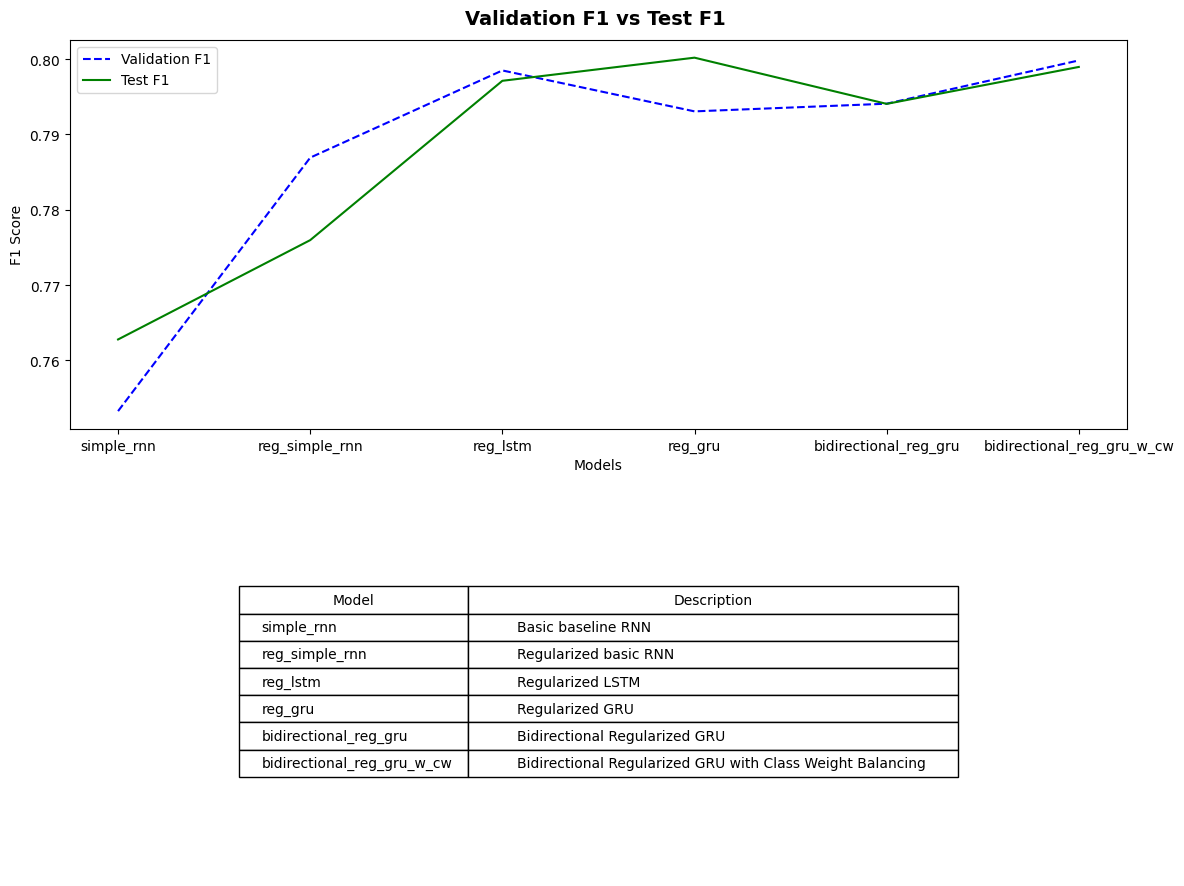

In [93]:
f1_score_comparison_manager.display_results()

I used the macro average F1 score in the plot. This seems to line up best with my scores as reported by Kaggle. The validation and test scores seem to match up nicely.

## <span style="color: royalblue;">Summary, Discussion, and Conclusion</span>

I started with a look at the data. From that I saw that there were a number of NaN values in two columns: keyword and location. Because these columns weren't going to be used, rather than doing some data imputation with these fields, I just removed those columns. I learned that the text columns is of type object. From doing research, Pandas recommends to use StringDtype, so I converted that it to that in the data cleanup section.

In the EDA and data cleanup section I learned from doing research, Pandas recommends to use StringDtype for text data. From looking at the data in the previous section, I saw that the text data was of type object, so I converted that to StringDtype as recommended by Pandas. After this I verified there was no other missing data. Next, I checked for duplicate entries and found over 100 rows. I removed those as they could cause overfitting of the models, inflating the training accuracy values, and bias, especially with the relatively small amount of data we are working with in this project. The word-frequency histograms helped me identify text that needed to be removed. This was mainly the shorthand pattern to old Twitter URLs. There were some other words removed that might cause difficulty for the model when it is learning to classify the different entries. With some text statistics I learned that the text length is rather consistent. This helped with deciding how to tokenize the data. Lastly I looked at the class distribution and leaned that there is a little imbalance favoring the non-disaster side.

As I mentioned in the introduction, I wanted to start out with a simple RNN model to get a baseline to later determine the usefulness of more complex models and hyperparameter tuning. It was clear that a simple RNN with no regularization overfit the training data as the validation accuracy diverged quickly. I added some basic regularization the this simple RNN to see how it could improve the training. Even though it did improve the training, I decided to move on to more complex models rather than spend time tuning the hyperparameters to get better results. I really wanted to look the LSTM and GRU architectures and how they would fair with this project.

I moved onto a LSTM model with regularization. An LSTM model is more complex than a simple RNN and therefore will have more trainable parameters. With more parameters there is the tendency to overfit the data more so I decided to immediately include regularization. I adjusted the regularization values a bit to account for the more complex model. While the graph looked better than the plain simple RNN, I didn't get the boost in scores (accuracy, F1, etc.) that I expected.

Next I moved on to the GRU architecture. The GRU is less complex than an LSTM so this by itself is a form of regularization. What I mean by that is with fewer parameters, it forces the model to generalize better. I also kept the regularization as a GRU is more complex than the simple RNN as well and will benefit from regularization. I think the plots (accuracy, loss, and AUC) looked better for this model.

I wanted to try out the GRU model with bidirectional support as this allowed this sequences to be processed in both directions. The reason for this is that words could have meaning based on the words around them. While a single direction RNN does take this into account, a bidirectional approach could do this better. The plots once again looked decent for this model, although not the boost in performance I was hoping for.

Lastly from what I learned in the EDA portion of the project was that the class distribution was imbalanced, favoring the non-disaster side. Because of the relatively small amount of data we were working with on this project, this could be significant. I decided to add class weight balancing to the previous model (bidirectional regularized GRU). The class weight balancing adds a penalty to the mistakes and showed to help the training a bit.

Because of the relatively small amount of data, I had to scale my initial models down quite a bit. While more complex models can learn deeper relationships, they generally require larger amounts of data. With small amounts of data, they risk overfitting the model which will lead to poor generalization.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">What worked well?</span>
* The data analysis, EDA, and data cleanup worked well in discovering important metrics on the data and what needed to be addressed before model building and training.
* The Tensorflow Tokenizer class was easy to work with and adjust.
* Getting practice with regularization and working with small amounts of data.
* The various plots helped visualize the changes.

<span style="font-size: 14px; font-weight: bold; color: royalblue;">What could be improved?</span>
* Overall I am happy with the results I did achieve, but I think with a bit more tuning (vocabulary length, max padding, batch size, regularization values, layer values, etc.) I could get even better results.
* The Tensorflow Tokenizer worked well, but using other NLP libraries such as Word2Vec could improve results.

## <span style="color: royalblue;">Resources</span>
* https://pandas.pydata.org/docs/user_guide/text.html
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
* https://www.kdnuggets.com/2020/03/tensorflow-keras-tokenization-text-data-prep.html
* https://www.geeksforgeeks.org/nlp-expand-contractions-in-text-processing/
* https://keras.io/api/layers/regularizers/
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding
* https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN